In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn.functional import relu
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms

In [4]:
import pickle

---
# Question-1
---

## Loading the MNIST dataset and performing train-validation-test split

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomCrop(size=28, padding=2),
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

The values 0.1307 and 0.3081 used for the Normalize() transformation are the global mean and standard deviation of the MNIST dataset.

In [6]:
mnist_dataset = datasets.MNIST('', train=True, download=True, transform=None)
mnist_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train

In [7]:
mnist_testset = datasets.MNIST('', train=False, download=True, transform=test_transform)
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: 
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Train-validation-test split

In [8]:
mnist_trainset, mnist_valset = random_split(mnist_dataset, [50000, 10000])

In [9]:
len(mnist_trainset), len(mnist_valset)

(50000, 10000)

In [10]:
mnist_trainset[0][0]

In [11]:
mnist_trainset[0][1]

9

In [12]:
mnist_testset[0][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [13]:
mnist_testset[0][1]

7

### Applying augmentations to images

In [14]:
mnist_trainset = list(mnist_trainset)
mnist_valset = list(mnist_valset)

In [15]:
for each in range(len(mnist_trainset)):
    mnist_trainset[each] = (train_transform(mnist_trainset[each][0]), mnist_trainset[each][1])

In [16]:
for each in range(len(mnist_valset)):
    mnist_valset[each] = (test_transform(mnist_valset[each][0]), mnist_valset[each][1])

In [17]:
mnist_trainset[0][0].shape, mnist_trainset[0][0].dtype

(torch.Size([1, 28, 28]), torch.float32)

In [18]:
mnist_valset[0][0].shape, mnist_valset[0][0].dtype

(torch.Size([1, 28, 28]), torch.float32)

In [19]:
mnist_testset[0][0].shape, mnist_testset[0][0].dtype

(torch.Size([1, 28, 28]), torch.float32)

## Plotting few images from each class

In [20]:
images_dict = {}
for each in range(0, 10):
    images_dict[each] = []

img_counter = 0

for each in range(len(mnist_trainset)):
    if img_counter > 50:
        break
    img = mnist_trainset[each][0]
    label = mnist_trainset[each][1]
    if len(images_dict[label]) < 5:
        images_dict[label].append(img)
        img_counter += 1

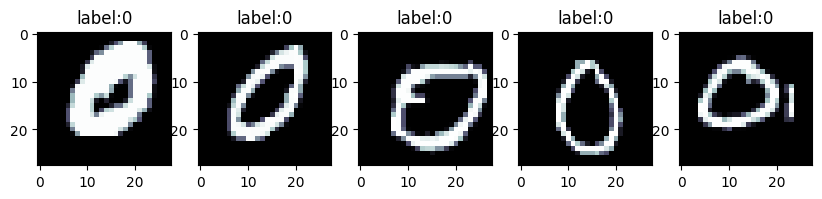

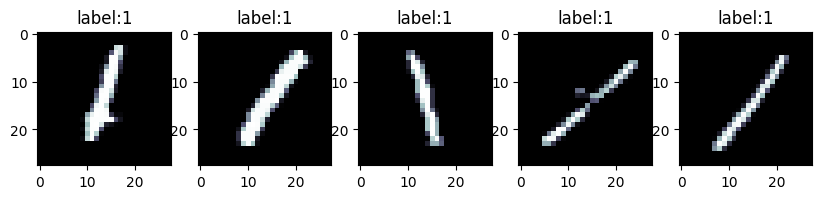

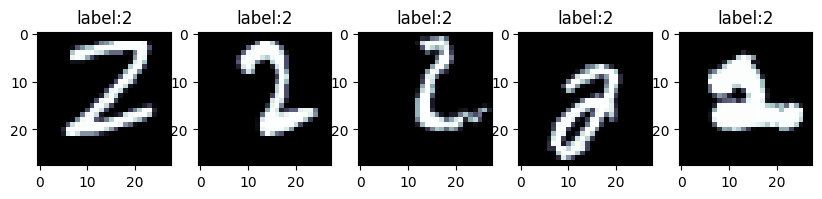

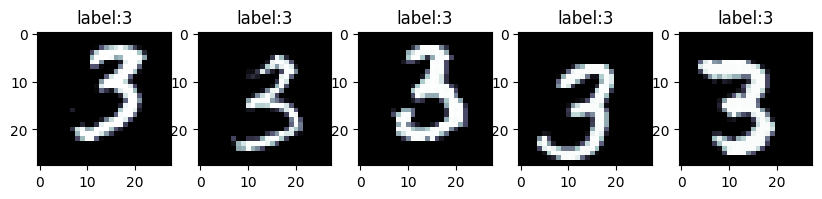

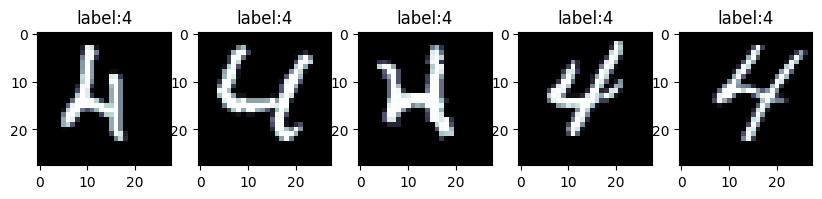

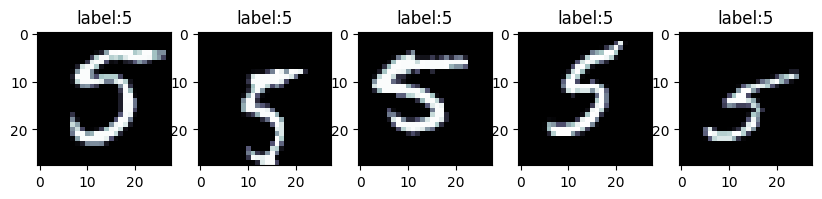

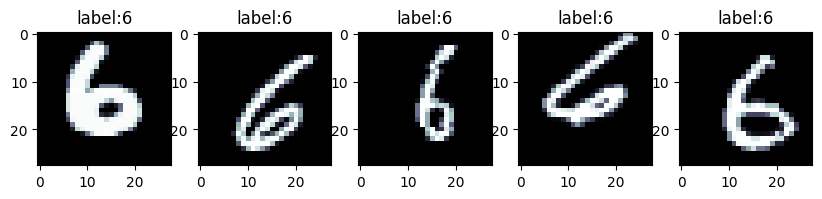

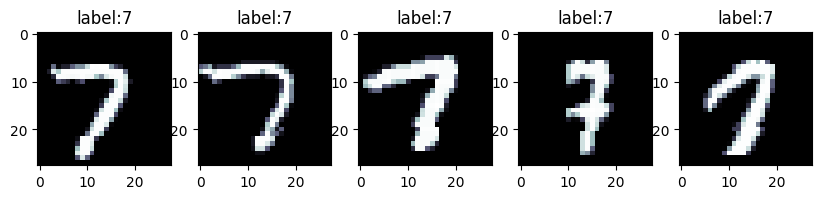

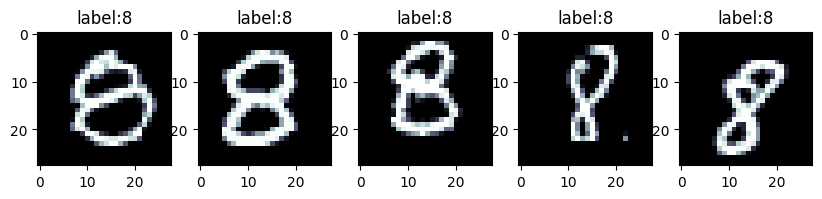

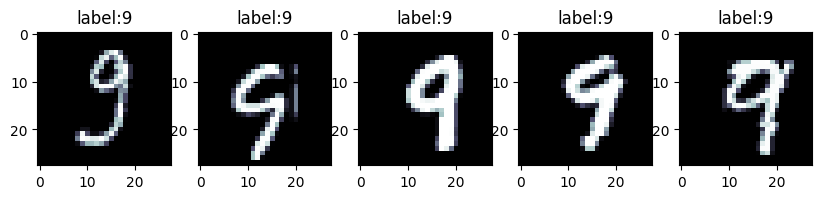

In [21]:
counter=0
for num in images_dict.keys():
    fig = plt.figure(figsize=(10,2))
    for each in range(1, 5+1):
        plt.subplot(1, 5, each)
        plt.imshow(images_dict[num][each-1].permute(1,2,0), cmap='bone')
        plt.title(f'label:{num}')
    counter+=1
    plt.show()

## Data loader for training set and testing set

In [22]:
train_loader = DataLoader(dataset=mnist_trainset, batch_size=64, shuffle=False)
val_loader = DataLoader(dataset=mnist_valset, batch_size=1000, shuffle=False)
test_loader = DataLoader(dataset=mnist_testset, batch_size=1000, shuffle=False)

## 3-Layer MLP (all using linear layers)

In [23]:
class MLP_PyTorch(nn.Module):
    def __init__(self, num_input_nodes, num_hidden_nodes_1, num_hidden_nodes_2, num_output_nodes):
        '''
        Input: numbers of nodes in the layers
        
        Constructor
        '''
        super().__init__()
        self.hidden_layer_1 = nn.Linear(num_input_nodes, num_hidden_nodes_1)
        self.hidden_layer_2 = nn.Linear(num_hidden_nodes_1, num_hidden_nodes_2)
        self.output_layer = nn.Linear(num_hidden_nodes_2, num_output_nodes)
        
        print('Number of trainable parameters:-')
        for param in self.parameters():
            print(f'{param.numel()}')

    
    def forward(self, x):
        '''
        Input: input layer dataset
        
        Returns the result of forward propagation by the model on the input
        '''
        x = x.reshape(x.shape[0], -1)
        x = relu(self.hidden_layer_1(x))
        x = relu(self.hidden_layer_2(x))
        x = self.output_layer(x)
        
        return x

    
    def save(self, path='best_model.pth'):
        '''
        Saves the model
        '''
        torch.save(self.state_dict(), path)

        
    def load(self, path='best_model.pth'):
        '''
        Loads the model
        '''
        self.load_state_dict(torch.load(path))
        self.eval()
        
        
    def fit(self, train_loader, val_loader,
              optimizer=Adam, loss_function=CrossEntropyLoss(), learning_rate=0.005, epochs=5):
        '''
        Input: Dataloader of the training dataset,
               Dataloader of the validation dataset
               optimizer (default = Adam),
               loss function (default = Cross Entropy loss),
               learning rate for the model (default = 0.005),
               number of epochs (default = 5)
        
        Trains the model, displays the training loss and
        the validation accuracy after each epoch, and
        also saves the best model at the end of each epoch
        '''
        best_accuracy = 0
        
        self.optimizer = optimizer(self.parameters(), lr=learning_rate)
        self.loss_func = loss_function
        self.epochs = epochs
        
        self.loss_epochs = list()
        self.acc_epochs = list()
        self.epoch_arr = [each+1 for each in range(self.epochs)]
        
        for epoch in range(self.epochs):
            for batch in train_loader:
                train_X, train_y = batch
                pred_train_y = self.forward(train_X)

                loss = self.loss_func(pred_train_y, train_y)

                # applying backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            # checking model performance on the validation set
            total_val_data = len(val_loader.dataset)
            correct_predictions = 0
            for batch in val_loader:
                val_X, val_y = batch
                val_pred_y = self.forward(val_X)
                for each in range(len(val_y)):
                    pred = int(torch.argmax(val_pred_y[each]))
                    true = int(val_y[each])
                    if pred == true:
                        correct_predictions += 1      

            val_acc = correct_predictions / total_val_data

            # saving the best model
            if val_acc > best_accuracy:
                self.save()

            # printing epoch-loss and validation-accuracy of the model
            epoch_loss = loss.item()
    
            self.loss_epochs.append(epoch_loss)
            self.acc_epochs.append(val_acc)
            
            print(f'epoch: {epoch+1}, loss: {epoch_loss}')
            print(f'validation accuracy: {val_acc}')
            print('-'*100)
            
        self.epochs_graphs()
            
            
    def test(self, test_loader):
        '''
        Input: Dataloader for the testing dataset
        
        Displays the model accuracy on the input
        '''
        # loading the best model
        self.load()
        
        total_test_data = len(test_loader.dataset)
        
        self.test_plot_correct = list()
        self.test_plot_incorrect = list()
        self.test_plot_arr_correct = list()
        self.test_plot_arr_incorrect = list()
        corr_plot_counter = 10
        incorr_plot_counter = 10 
        
        correct_predictions = 0
        for batch in test_loader:
            test_X, test_y = batch
            test_pred_y = self.forward(test_X)

            for each in range(len(test_y)):
                pred = int(torch.argmax(test_pred_y[each]))
                true = int(test_y[each])
                if pred == true:
                    correct_predictions += 1
                    if corr_plot_counter > 0:
                        self.test_plot_correct.append(test_X[each])
                        self.test_plot_arr_correct.append({'actual':true, 'predicted':pred})
                        corr_plot_counter -= 1
                else:
                    if incorr_plot_counter > 0:
                        self.test_plot_incorrect.append(test_X[each])
                        self.test_plot_arr_incorrect.append({'actual':true, 'predicted':pred})
                        incorr_plot_counter -= 1

        test_acc = correct_predictions / total_test_data
        print(f'Testing accuracy: {test_acc}')
        print('-'*100)
        
        self.test_graph()

        
    def epochs_graphs(self):
        '''
        Visualizes the loss-epoch and accuracy-epoch graphs for both training and validation
        '''
        figure = plt.figure(figsize=(12, 4))
        
        plt.subplot(1,2,1)
        plt.plot(self.epoch_arr, self.loss_epochs, 'o-', color='lightseagreen')
        plt.ylabel('epoch-training-loss')
        plt.xlabel('number of epochs')
        
        plt.subplot(1,2,2)
        plt.plot(self.epoch_arr, self.acc_epochs, 'o-', color='hotpink')
        plt.ylabel('epoch-validation-accuracy')
        plt.xlabel('number of epochs')
        plt.show()
        
        
    def test_graph(self):
        '''
        Visualizes the correct and incorrect predictions on the test data
        '''
        print('some of the correct predictions in the testing dataset:-')
        for num in range(2):
            fig = plt.figure(figsize=(10,2))
            for each in range(num*5, 5*(num+1)):
                plt.subplot(1, 5, each+1-(num*5))
                plt.imshow(self.test_plot_correct[each].permute(1,2,0), cmap='bone')
                Title = f"actual label:{self.test_plot_arr_correct[each]['actual']}\n"\
                     f"predicted label:{self.test_plot_arr_correct[each]['predicted']}"
                plt.title(Title, color='springgreen')
            plt.show()
            
        print('-'*100)
        print('some of the incorrect predictions in the testing dataset:-')
        
        for num in range(2):
            fig = plt.figure(figsize=(10,2))
            for each in range(num*5, 5*(num+1)):
                plt.subplot(1, 5, each+1-(num*5))
                plt.imshow(self.test_plot_incorrect[each].permute(1,2,0), cmap='bone')
                Title = f"actual label:{self.test_plot_arr_incorrect[each]['actual']}\n"\
                     f"predicted label:{self.test_plot_arr_incorrect[each]['predicted']}"
                plt.title(Title, color='orangered')
            plt.show()
        

### Initializing the MLP model

In [24]:
model = MLP_PyTorch(num_input_nodes=28*28, num_hidden_nodes_1=256, num_hidden_nodes_2=256, num_output_nodes=10)

Number of trainable parameters:-
200704
256
65536
256
2560
10


### Training the model

epoch: 1, loss: 0.44838428497314453
validation accuracy: 0.9346
----------------------------------------------------------------------------------------------------
epoch: 2, loss: 0.15029026567935944
validation accuracy: 0.939
----------------------------------------------------------------------------------------------------
epoch: 3, loss: 0.058974701911211014
validation accuracy: 0.9543
----------------------------------------------------------------------------------------------------
epoch: 4, loss: 0.23393379151821136
validation accuracy: 0.9574
----------------------------------------------------------------------------------------------------
epoch: 5, loss: 0.07298774272203445
validation accuracy: 0.9454
----------------------------------------------------------------------------------------------------


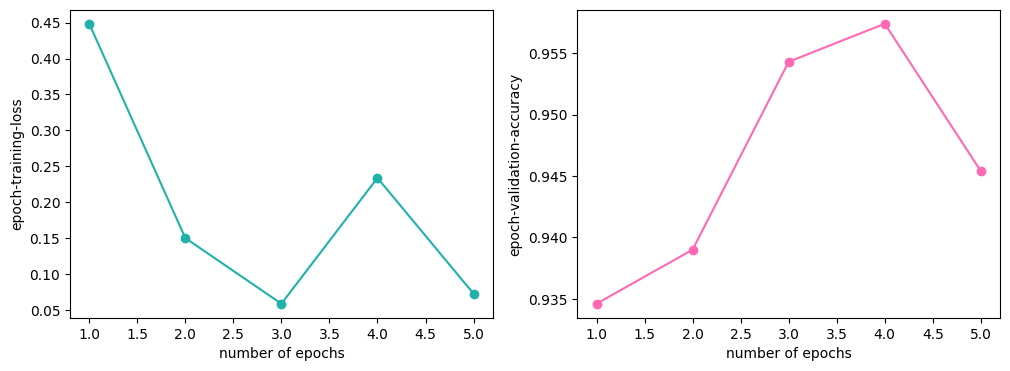

In [25]:
model.fit(train_loader, val_loader, learning_rate=0.005)

### Testing and performance

Testing accuracy: 0.9466
----------------------------------------------------------------------------------------------------
some of the correct predictions in the testing dataset:-


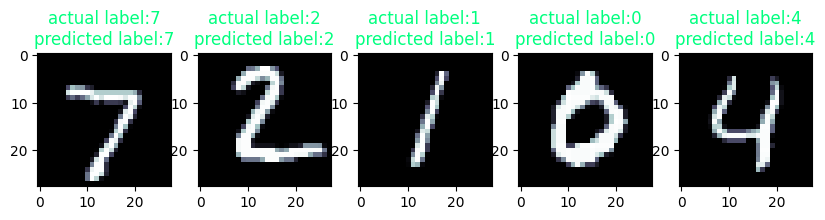

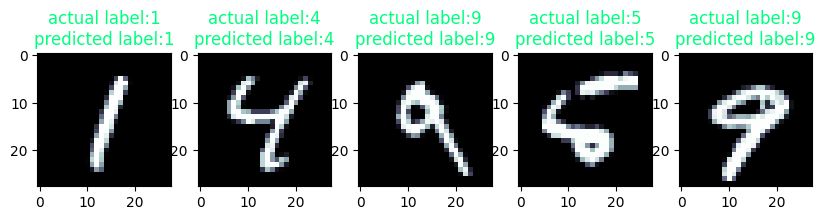

----------------------------------------------------------------------------------------------------
some of the incorrect predictions in the testing dataset:-


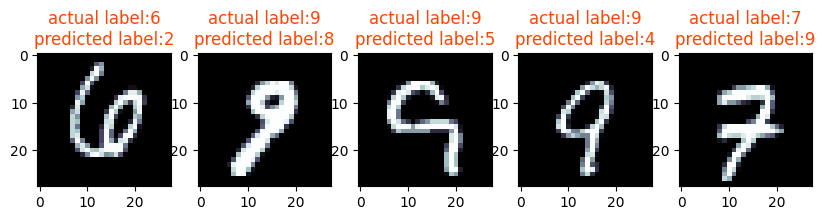

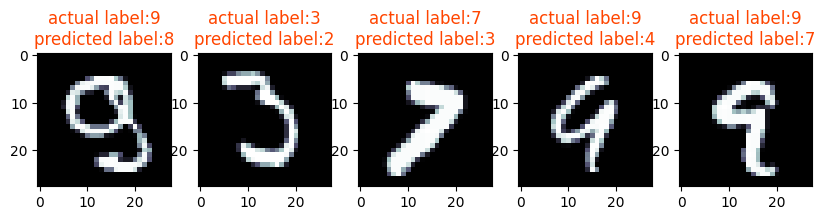

In [26]:
model.test(test_loader)

---
# Question-2 (Artificial Neural Network from scratch)
---

## Preprocesing and Data visualization

### Loading the dataset

In [27]:
abalone_df = pd.read_csv('abalone.csv')
abalone_df_raw = abalone_df.copy()

In [28]:
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


### Data Analysis

In [29]:
abalone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [30]:
abalone_df.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [31]:
Classes = np.array(sorted(abalone_df.Rings.unique()))
Classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

In [32]:
features = abalone_df.columns.tolist()[:-1]
features

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Shucked weight',
 'Viscera weight',
 'Shell weight']

### Data visualization

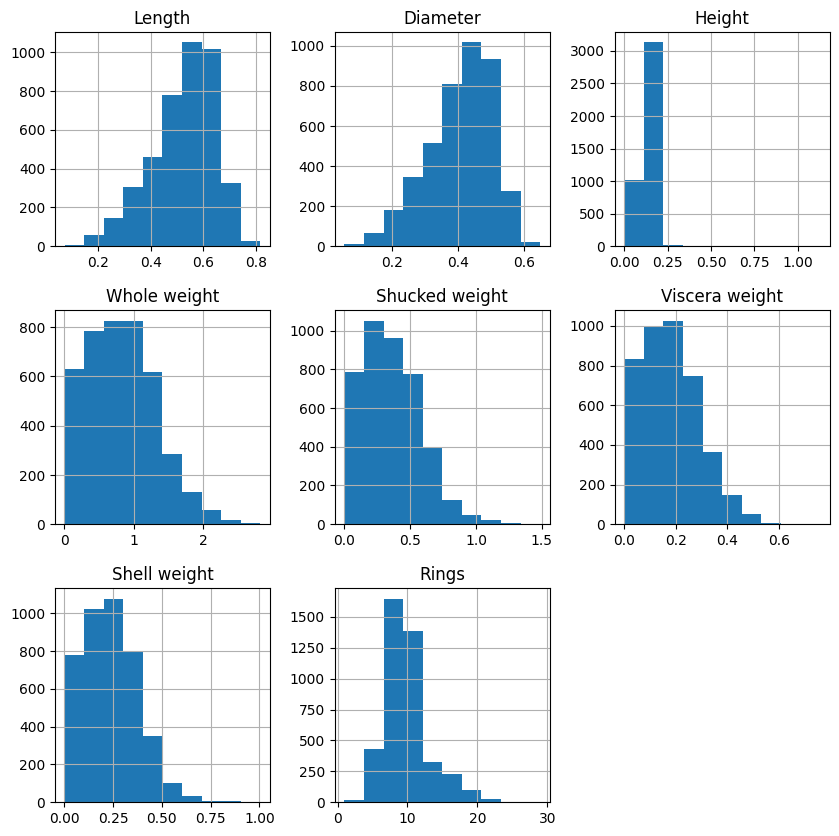

In [33]:
abalone_df.hist(figsize=(10,10))
plt.show()

### Encoding categorical features

In [34]:
abalone_df['Sex'] = abalone_df['Sex'].astype('category').cat.codes

### Binning the labels to convert into classification problem

In [35]:
Classes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29])

In [36]:
labels_array = list(np.array(abalone_df['Rings']))
# labels_array

In [37]:
for each in range(len(labels_array)):
    if labels_array[each] <= 10:
        labels_array[each] = 'young-age'
    elif labels_array[each] <= 20:
        labels_array[each] = 'middle-age'
    else:
        labels_array[each] = 'old-age'

In [38]:
abalone_df.Rings = labels_array

In [39]:
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,middle-age
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,young-age
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,young-age
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,young-age
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,young-age
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,middle-age
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,young-age
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,young-age
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,young-age


In [40]:
abalone_df['Rings'][abalone_df['Rings']=='young-age'] = 0
abalone_df['Rings'][abalone_df['Rings']=='middle-age'] = 1
abalone_df['Rings'][abalone_df['Rings']=='old-age'] = 2

In [41]:
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,1
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,0
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,0
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,0
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,0
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,1
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,0
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,0
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,0


In [42]:
abalone_X = abalone_df[features].copy()
abalone_y = abalone_df['Rings'].copy()

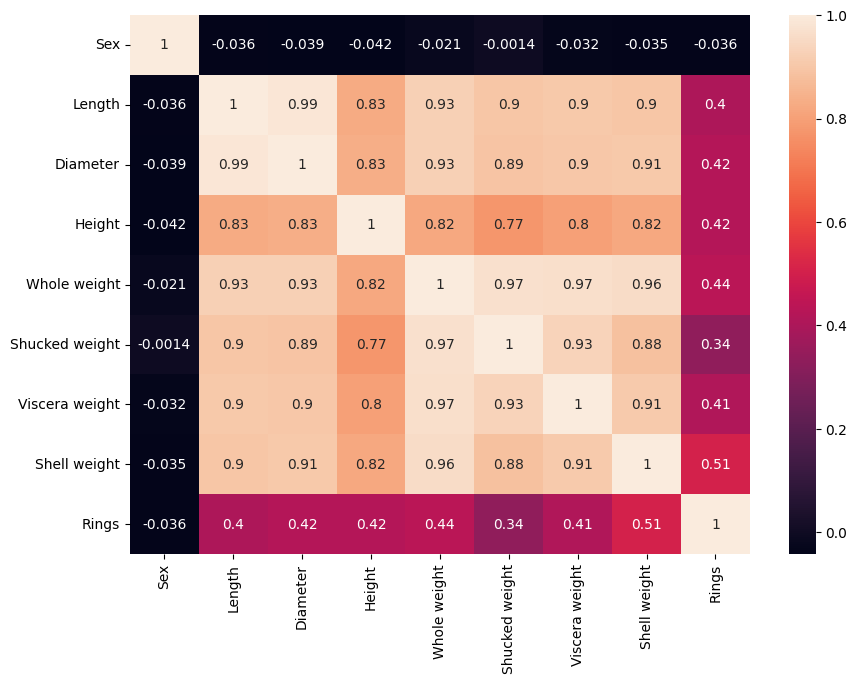

In [104]:
figure = plt.figure(figsize=(10,7))
sns.heatmap(abalone_df.corr(), annot=True)
plt.show()

### Stratified Splitting into train-validation-test sets

In [43]:
def stratified_splitting(dataframe, feature_col_names, label_col_name, train=0.7, val=0.1, test=0.2):
    data = np.array(dataframe)
    
    all_cols = feature_col_names.copy()
    all_cols.append(label_col_name)
    
    train_data = []
    val_data = []
    test_data = []
    
    class_array = data[:, -1]
    
    unique_classes = np.unique(class_array)
    
    for each in unique_classes:
        datapoints = data[class_array==each]
        np.random.shuffle(datapoints)
        num_datapoints = len(datapoints)
        num_train = int(train*num_datapoints)
        num_val = int(val*num_datapoints)
        
        train_data.append(datapoints[:num_train])
        val_data.append(datapoints[num_train: num_train+num_val])
        test_data.append(datapoints[(num_train+num_val):])

    train_data = np.concatenate(train_data)
    val_data = np.concatenate(val_data)
    test_data = np.concatenate(test_data)
    
    train_data = pd.DataFrame(train_data)
    val_data = pd.DataFrame(val_data)
    test_data = pd.DataFrame(test_data)
    
    train_data.columns = all_cols
    val_data.columns = all_cols
    test_data.columns = all_cols
    
    train_X = train_data[feature_col_names]
    train_y = train_data[label_col_name]
    
    val_X = val_data[feature_col_names]
    val_y = val_data[label_col_name]
    
    test_X = test_data[feature_col_names]
    test_y = test_data[label_col_name]
    
    return (train_X, train_y, val_X, val_y, test_X, test_y)
    

In [44]:
train_X, train_y, val_X, val_y, test_X, test_y = \
    stratified_splitting(dataframe=abalone_df, feature_col_names=features, label_col_name='Rings')

In [45]:
train_X

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,1,0.2,0.155,0.04,0.0435,0.0155,0.009,0.007
1,2,0.575,0.455,0.135,0.907,0.4245,0.197,0.26
2,0,0.55,0.405,0.125,0.651,0.2965,0.137,0.2
3,2,0.565,0.43,0.15,0.831,0.4245,0.1735,0.219
4,0,0.595,0.44,0.135,0.964,0.5005,0.1715,0.2575
...,...,...,...,...,...,...,...,...
2917,0,0.665,0.5,0.175,1.742,0.595,0.3025,0.725
2918,0,0.645,0.49,0.215,1.406,0.4265,0.2285,0.51
2919,0,0.56,0.455,0.125,0.943,0.344,0.129,0.375
2920,2,0.64,0.51,0.175,1.368,0.515,0.266,0.57


In [46]:
val_X

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,1,0.355,0.265,0.085,0.2435,0.122,0.0525,0.06
1,0,0.64,0.5,0.15,1.0705,0.371,0.2705,0.36
2,1,0.425,0.325,0.105,0.3975,0.1815,0.081,0.1175
3,2,0.545,0.41,0.12,0.793,0.434,0.1405,0.19
4,1,0.25,0.185,0.065,0.071,0.027,0.0185,0.0225
...,...,...,...,...,...,...,...,...
412,2,0.695,0.55,0.195,1.6645,0.727,0.36,0.445
413,2,0.625,0.495,0.175,1.2075,0.531,0.281,0.3525
414,0,0.62,0.47,0.2,1.2255,0.381,0.27,0.435
415,2,0.49,0.39,0.15,0.573,0.225,0.124,0.17


In [47]:
test_X

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
0,1,0.26,0.2,0.07,0.092,0.037,0.02,0.03
1,2,0.575,0.455,0.165,0.867,0.3765,0.1805,0.268
2,0,0.55,0.415,0.18,1.1655,0.502,0.301,0.311
3,2,0.26,0.19,0.075,0.0945,0.0445,0.02,0.03
4,1,0.37,0.28,0.085,0.198,0.0805,0.0455,0.058
...,...,...,...,...,...,...,...,...
833,0,0.7,0.585,0.185,1.8075,0.7055,0.3215,0.475
834,2,0.625,0.505,0.215,1.4455,0.496,0.287,0.435
835,0,0.8,0.63,0.195,2.526,0.933,0.59,0.62
836,0,0.55,0.465,0.18,1.2125,0.3245,0.205,0.525


In [48]:
# train_X, val_test_X, train_y, val_test_y = train_test_split(abalone_X, abalone_y, test_size=0.3, random_state=0, stratify=abalone_y)
# test_X, val_X, test_y, val_y = train_test_split(val_test_X, val_test_y, test_size=0.33, random_state=0, stratify=val_test_y)

## Multi-layer perceptron from scratch

In [49]:
class MLP:
    def __init__(self, X, y, hidden_layers=None, num_hidden_layers=2, num_hidden_nodes=None, \
                 activation_function='sigmoid', lr=0.05, weights_type='Random', iterations=100):
        '''
        Inputs: training dataset and labels, information regarding hidden layers,
                activation function, learning rate, weights type for initialization, number of iterations
        
        Constructor for the Multi-layer Perceptron
        '''
        self.X = X
        self.y = y
        
        self.num_datapoints, self.num_input_nodes = np.array(self.X).shape
        self.output_nodes = np.sort(np.unique(self.y))
        self.num_output_nodes = len(self.output_nodes)
            
        if hidden_layers is not None:
            self.hidden_layers = hidden_layers
            self.num_hidden_layers = len(hidden_layers)
        else:
            self.num_hidden_layers = num_hidden_layers
            if num_hidden_nodes is None:
                self.num_hidden_nodes = int(math.sqrt(self.num_input_nodes*self.num_output_nodes))
            else:
                self.num_hidden_nodes = num_hidden_nodes
                
            self.hidden_layers = [self.num_hidden_nodes for each in range(self.num_hidden_layers)]
        
        self.activation_function = activation_function
        
        # initializing weights
        self.weights = list()
        if weights_type == 'Random':
            for each in range(self.num_hidden_layers+1):
                if each == 0:
                    self.weights.append(np.random.rand(self.hidden_layers[each], self.num_input_nodes))
                elif each == self.num_hidden_layers:
                    self.weights.append(np.random.rand(self.num_output_nodes, self.hidden_layers[each-1]))
                else:
                    self.weights.append(np.random.rand(self.hidden_layers[each], self.hidden_layers[each-1]))

        elif weights_type == 'Zero':
            for each in range(self.num_hidden_layers+1):
                if each == 0:
                    self.weights.append(np.zeros((self.hidden_layers[each], self.num_input_nodes)))
                elif each == self.num_hidden_layers:
                    self.weights.append(np.zeros((self.num_output_nodes, self.hidden_layers[each-1])))
                else:
                    self.weights.append(np.zeros((self.hidden_layers[each], self.hidden_layers[each-1])))

        elif weights_type == 'Constant':
            for each in range(self.num_hidden_layers+1):
                if each == 0:
                    self.weights.append(np.ones((self.hidden_layers[each], self.num_input_nodes)))
                elif each == self.num_hidden_layers:
                    self.weights.append(np.ones((self.num_output_nodes, self.hidden_layers[each-1])))
                else:
                    self.weights.append(np.ones((self.hidden_layers[each], self.hidden_layers[each-1])))
            
        # initializing biases
        self.biases = list()
        for each in range(len(self.weights)):
            self.biases.append(np.ones((self.weights[each].shape[0], 1)))
        
        '''
        print('Weights shapes:-')
        print([each.shape for each in self.weights])
        
        print('Biases shapes:-')
        print([each.shape for each in self.biases])
        '''
        
        # layers before activation
        self.in_layers = list()
        # layers after activation
        self.out_layers = list()
        
        # learning rate
        self.lr = lr
        
        # number of iterations
        self.iterations = iterations
        self.current_itr = 1
        
        self.f_counter = 0
        self.b_counter = 0
        
        self.gradients_out_layers = list()
        self.gradients_weights = list()
        self.gradients_biases = list()
        
        # expected outputs matrix
        self.expected_outputs = np.zeros((self.num_output_nodes, self.num_datapoints))
        for each in range(len(self.y)):
            self.expected_outputs[:, each][self.y[each]] = 1
            
        self.ActivationFunctions = {'sigmoid': self.sigmoid, 'tanh': self.tanh, 'relu': self.relu}
        self.Derivatives = {'sigmoid': self.deriv_sigmoid, 'tanh': self.deriv_tanh, 'relu': self.deriv_relu}
        
        self.iterations_array = list()
        self.costs_array = list()
        self.train_acc_array = list()
        self.val_acc_array = list()
        
    
    '''activation functions for the hidden layers'''
    # Sigmoid
    def sigmoid(self, x):
        '''
        Sigmoid function
        Returns the output of sigmoid function applied on the input
        '''
        x = x.astype(np.float64)
        return 1 / (1 + np.exp(-x))

    def deriv_sigmoid(self, x):
        '''
        Returns the derivative of sigmoid function for the input
        '''
        x = x.astype(np.float64)
        return self.sigmoid(x) * (1 - self.sigmoid(x))


    # tanH
    def tanh(self, x):
        '''
        tanH function
        Returns the output of hyperbolic tangent function applied on the input
        '''
        x = x.astype(np.float64)
        return np.tanh(x)

    def deriv_tanh(self, x):
        '''
        Returns the derivative of tanh function for the input
        '''
        x = x.astype(np.float64)
        return 1 - np.tanh(x)**2


    # ReLU
    def relu(self, x):
        '''
        ReLU function
        Returns the output of rectified linear unit function applied on the input
        '''
        x = x.astype(np.float64)
        return np.maximum(0, x)

    def deriv_relu(self, x):
        '''
        Returns the derivative of the relu function for the input
        '''
        return np.array([(each >= 0) for each in x])

    
    '''activation function for the output layer'''
    # Softmax function
    def softmax(self, x):
        '''
        Softmax function
        Returns the output of softmax function applied on the input
        '''
        x = x.astype(np.float64)
        return np.exp(x) / np.sum(np.exp(x), axis=0)
    
    
    # Cost function
    def categorical_cross_entropy_loss(self, expected, predicted):
        '''
        Categorical Cross Entropy loss function
        '''
        loss = -np.sum(expected*(np.log(predicted+1e-15))) / expected.shape[0]
        return loss

    
    def forward_propagation(self):
        '''
        Forward Propagation of the input
        '''
        activation_function = self.ActivationFunctions[self.activation_function]
        
        if self.f_counter == 0:
            self.f_counter = 1
            
            input_layer = np.array(self.X).T
            self.in_layers.append(input_layer)
            self.out_layers.append(input_layer)
            
            for each in range(self.num_hidden_layers+1):
                prev_layer = self.in_layers[each]
                weight = self.weights[each]
                
                new_layer = np.dot(weight, prev_layer) + self.biases[each]
                self.in_layers.append(new_layer)
                
                if each != self.num_hidden_layers:
                    self.out_layers.append(activation_function(new_layer))
                else:
                    self.out_layers.append(self.softmax(new_layer))
                    
        else:
            num_layers = len(self.in_layers)
            for each in range(1, num_layers):
                prev_layer = self.in_layers[each-1]
                weight = self.weights[each-1]
                
                new_layer = np.dot(weight, prev_layer) + self.biases[each-1]
                self.in_layers[each] = new_layer
                
                if each != num_layers-1:
                    self.out_layers[each] = activation_function(new_layer)
                else:
                    self.out_layers[each] = self.softmax(new_layer)
        '''
        print('Layers:-')
        print(f'in_layers: {[each.shape for each in self.in_layers]}')
        print(f'out_layers: {[each.shape for each in self.out_layers]}')
        '''

        
    def backward_propagation(self):
        '''
        Backward Propagation of the error using stochastic gradient descent
        Also updates the weights
        '''
        derivative = self.Derivatives[self.activation_function]
        
        num_layers = len(self.out_layers)
        
        if self.b_counter == 0:
            self.b_counter = 1
            
            # for the output layer (softmax is used here)
            self.gradients_out_layers.append(self.out_layers[num_layers-1] - self.expected_outputs)
            self.gradients_weights.append(1/self.num_datapoints * \
                    np.dot(self.gradients_out_layers[0], self.out_layers[num_layers-2].T))
            self.gradients_biases.append(1/self.num_datapoints * \
                    np.sum(self.gradients_out_layers[0], axis=1, keepdims=True))
            
            # for the rest of the layers:
            for each in range(num_layers-2, 0, -1):
                self.gradients_out_layers.append(\
                    np.dot(self.weights[each].T, self.gradients_out_layers[num_layers-2-each])\
                        * derivative(self.in_layers[each]))
                self.gradients_weights.append(1/self.num_datapoints * \
                    np.dot(self.gradients_out_layers[num_layers-1-each], self.out_layers[each-1].T))
                self.gradients_biases.append(1/self.num_datapoints * \
                    np.sum(self.gradients_out_layers[num_layers-1-each], axis=1, keepdims=True))
                
        else:
            # for the output layer (softmax is used here)
            self.gradients_out_layers[0] = self.out_layers[num_layers-1] - self.expected_outputs
            self.gradients_weights[0] = (1/self.num_datapoints * \
                    np.dot(self.gradients_out_layers[0], self.out_layers[num_layers-2].T))
            self.gradients_biases[0] = (1/self.num_datapoints * \
                    np.sum(self.gradients_out_layers[0], axis=1, keepdims=True))
            
            # for the rest of the layers:
            for each in range(num_layers-2, 0, -1):
                self.gradients_out_layers[num_layers-1-each] = (\
                    np.dot(self.weights[each].T, self.gradients_out_layers[num_layers-2-each])\
                        * derivative(self.in_layers[each]))
                self.gradients_weights[num_layers-1-each] = (1/self.num_datapoints * \
                    np.dot(self.gradients_out_layers[num_layers-1-each], self.out_layers[each-1].T))
                self.gradients_biases[num_layers-1-each] = (1/self.num_datapoints * \
                    np.sum(self.gradients_out_layers[num_layers-1-each], axis=1, keepdims=True))
        
        # updating weights
        for each in range(num_layers-1):
            self.weights[each] = self.weights[each] - self.lr*self.gradients_weights[num_layers-2-each]
            self.biases[each] = self.biases[each] - self.lr*self.gradients_biases[num_layers-2-each]
            
    
    def return_training_accuracy(self):
        '''
        Returns training accuracy
        '''
        predicted_y = self.out_layers[-1].T
        prediction_array = list()
        
        for each in range(self.num_datapoints):
            prediction_array.append(np.argmax(predicted_y[each]))
        prediction_array = np.array(prediction_array)
        
        # return prediction_array
        accuracy = 0
        for each in range(self.num_datapoints):
            if self.y[each] == prediction_array[each]:
                accuracy += 1
        accuracy /= self.num_datapoints
        
        return accuracy
    
    
    def return_training_cost(self):
        '''
        Returns training cost
        '''
        return self.categorical_cross_entropy_loss(self.expected_outputs.T, self.out_layers[-1].T)
    
    
    def start(self, val_X, val_y, print_cost=True):
        '''
        Starts training the model, updates the weights and also prints cost value for each 100th iteration
        '''
        for each in range(1, self.iterations+1):
            self.forward_propagation()
            self.backward_propagation()

            if each % 100 == 0:
                cost = self.return_training_cost()
                self.iterations_array.append(each)
                self.costs_array.append(cost)
                self.train_acc_array.append(self.return_training_accuracy())
                self.val_acc_array.append(self.score(val_X, val_y))
                
                if print_cost:
                    # print(f'iteration = {each+1}, training accuracy = {self.return_training_accuracy()}')
                    print(f'iteration = {each}, cost = {cost}')
            
        
    def score(self, X, y):
        '''
        Input: testing dataset and labels
        
        Returns accuracy score for the predictions on the given data
        '''
        activation_function = self.ActivationFunctions[self.activation_function]
        
        in_layers = list()
        out_layers = list()
        
        input_layer = np.array(X).T
        in_layers.append(input_layer)
        out_layers.append(input_layer)

        for each in range(self.num_hidden_layers+1):
            prev_layer = in_layers[each]
            weight = self.weights[each]

            new_layer = np.dot(weight, prev_layer) + self.biases[each]
            in_layers.append(new_layer)

            if each != self.num_hidden_layers:
                out_layers.append(activation_function(new_layer))
            else:
                out_layers.append(self.softmax(new_layer))
                
        num_datapoints = len(y)
        predicted_y = out_layers[-1].T
        prediction_array = list()
        
        for each in range(num_datapoints):
            prediction_array.append(np.argmax(predicted_y[each]))
        prediction_array = np.array(prediction_array)
        
        # return prediction_array
        accuracy = 0
        for each in range(num_datapoints):
            if y[each] == prediction_array[each]:
                accuracy += 1
        accuracy /= num_datapoints
        
        return accuracy

    def plots(self):
        fig = plt.figure(figsize=(5, 12))
        plt.subplot(3, 1, 1)
        plt.plot(self.iterations_array, self.costs_array, 'o-')
        plt.xlabel('number of iterations')
        plt.ylabel('cost values')
        
        plt.subplot(3, 1, 2)
        plt.plot(self.iterations_array, self.train_acc_array, 'o-')
        plt.xlabel('number of iterations')
        plt.ylabel('train accuracy values')
        
        plt.subplot(3, 1, 3)
        plt.plot(self.iterations_array, self.val_acc_array, 'o-')
        plt.xlabel('number of iterations')
        plt.ylabel('validation accuracy values')
        
        plt.show()

---
## Sigmoid activation function
---

### Random weight initialization

In [50]:
mlp_sigmoid_random = MLP(train_X, train_y, hidden_layers=[4], weights_type='Random', lr=0.3, iterations=3000)
mlp_sigmoid_random.start(val_X, val_y)

iteration = 100, cost = 0.6892691865045373
iteration = 200, cost = 0.655973122331852
iteration = 300, cost = 0.6331961889480694
iteration = 400, cost = 0.6191116216930764
iteration = 500, cost = 0.6101633968462545
iteration = 600, cost = 0.6037640800365246
iteration = 700, cost = 0.5988791468578906
iteration = 800, cost = 0.5951192553067615
iteration = 900, cost = 0.5922533470808193
iteration = 1000, cost = 0.5900685541129014
iteration = 1100, cost = 0.5883626223144567
iteration = 1200, cost = 0.5869685060119151
iteration = 1300, cost = 0.5857669962045953
iteration = 1400, cost = 0.5846820439578435
iteration = 1500, cost = 0.5836686016760738
iteration = 1600, cost = 0.5827009610536036
iteration = 1700, cost = 0.5817644032840131
iteration = 1800, cost = 0.5808500464834092
iteration = 1900, cost = 0.5799519348244301
iteration = 2000, cost = 0.5790654846630572
iteration = 2100, cost = 0.5781866847578616
iteration = 2200, cost = 0.5773116913402321
iteration = 2300, cost = 0.576436619202197

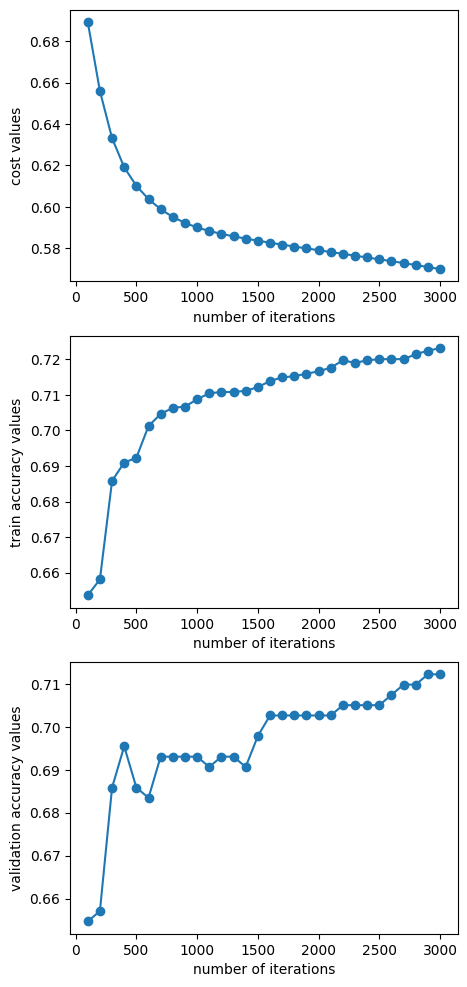

In [51]:
mlp_sigmoid_random.plots()

In [52]:
mlp_sigmoid_random.score(test_X, test_y)

0.7255369928400954

### Constant weight initialization

In [53]:
mlp_sigmoid_constant = \
    mlp_random = MLP(train_X, train_y, hidden_layers=[4], weights_type='Constant', lr=0.4, iterations=3000)
mlp_sigmoid_constant.start(val_X, val_y)

iteration = 100, cost = 1.513414577055913
iteration = 200, cost = 0.8839195136681008
iteration = 300, cost = 1.1698025749019763
iteration = 400, cost = 0.8776313985590598
iteration = 500, cost = 0.9652683949358964
iteration = 600, cost = 0.9847602022851975
iteration = 700, cost = 1.027089590588648
iteration = 800, cost = 1.0919677820420008
iteration = 900, cost = 1.1951419799550786
iteration = 1000, cost = 1.3143318427560835
iteration = 1100, cost = 1.2796715754214565
iteration = 1200, cost = 1.2144817573650855
iteration = 1300, cost = 1.1439994986714792
iteration = 1400, cost = 1.0681634555988564
iteration = 1500, cost = 0.9875365868937893
iteration = 1600, cost = 0.9039811899349338
iteration = 1700, cost = 0.8214919365627958
iteration = 1800, cost = 0.7464487753253651
iteration = 1900, cost = 0.6857615465495506
iteration = 2000, cost = 0.643151555785191
iteration = 2100, cost = 0.6180108614490077
iteration = 2200, cost = 0.608441655957427
iteration = 2300, cost = 0.6065753592074027
i

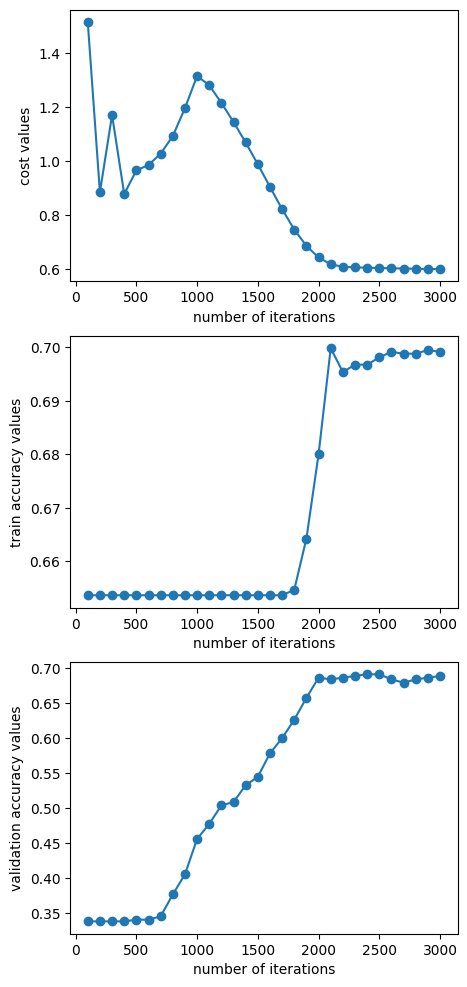

In [54]:
mlp_sigmoid_constant.plots()

In [55]:
mlp_sigmoid_constant.score(test_X, test_y)

0.7100238663484487

### Zero weight initialization

In [56]:
mlp_sigmoid_zero = \
    mlp_random = MLP(train_X, train_y, hidden_layers=[4], weights_type='Zero', lr=0.3, iterations=3000)
mlp_sigmoid_zero.start(val_X, val_y)

iteration = 100, cost = 0.6815541997292899
iteration = 200, cost = 0.6707339763468891
iteration = 300, cost = 0.6455477565630862
iteration = 400, cost = 0.6118426659155186
iteration = 500, cost = 0.5951483610776116
iteration = 600, cost = 0.5879183183050701
iteration = 700, cost = 0.5833603256105443
iteration = 800, cost = 0.5795138746858679
iteration = 900, cost = 0.5758097231426056
iteration = 1000, cost = 0.5720764995563
iteration = 1100, cost = 0.5682592295888849
iteration = 1200, cost = 0.5643367768364641
iteration = 1300, cost = 0.5602987211160859
iteration = 1400, cost = 0.5561409962675006
iteration = 1500, cost = 0.5518674013429858
iteration = 1600, cost = 0.5474925711713704
iteration = 1700, cost = 0.5430446732258776
iteration = 1800, cost = 0.5385668622552249
iteration = 1900, cost = 0.5341167051391633
iteration = 2000, cost = 0.5297629861457811
iteration = 2100, cost = 0.5255798138596216
iteration = 2200, cost = 0.5216387838308957
iteration = 2300, cost = 0.5180007893831501


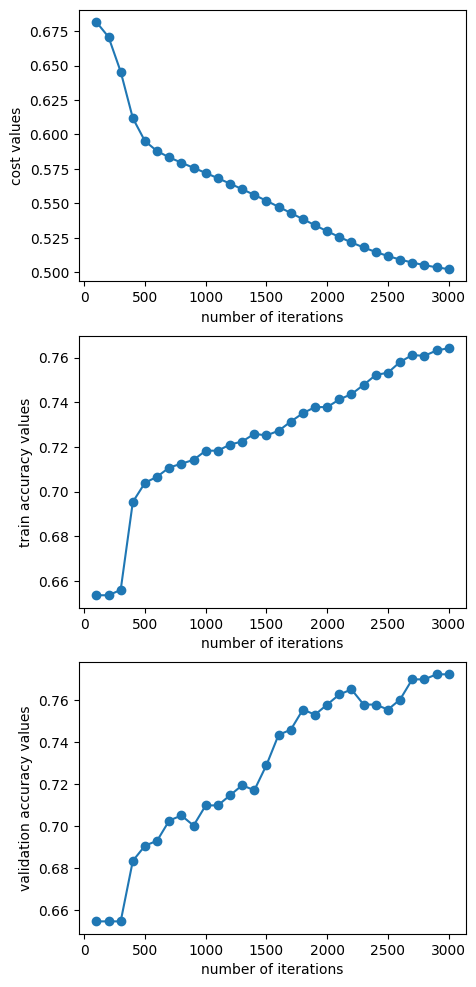

In [57]:
mlp_sigmoid_zero.plots()

In [58]:
mlp_sigmoid_zero.score(test_X, test_y)

0.7720763723150358

---
## ReLU activation function
---

### Random weight initialization

In [60]:
mlp_relu_random = MLP(train_X, train_y, hidden_layers=[4], weights_type='Random',\
                 activation_function='relu', lr=0.27, iterations=3000)
mlp_relu_random.start(val_X, val_y)

iteration = 100, cost = 0.6036901010479863
iteration = 200, cost = 0.5853336923023469
iteration = 300, cost = 0.5757294831652555
iteration = 400, cost = 0.5637552009983438
iteration = 500, cost = 0.5613596577380969
iteration = 600, cost = 0.5597672498453549
iteration = 700, cost = 0.5506763109229145
iteration = 800, cost = 0.5434735232627442
iteration = 900, cost = 0.5362051485149456
iteration = 1000, cost = 0.5306595431741805
iteration = 1100, cost = 0.5254065172666218
iteration = 1200, cost = 0.5207721738797921
iteration = 1300, cost = 0.5168503495691658
iteration = 1400, cost = 0.5134417875796481
iteration = 1500, cost = 0.510772598103695
iteration = 1600, cost = 0.508025366737152
iteration = 1700, cost = 0.5058284617567552
iteration = 1800, cost = 0.5038166887761937
iteration = 1900, cost = 0.501996406165825
iteration = 2000, cost = 0.5004859296464677
iteration = 2100, cost = 0.4991946589478098
iteration = 2200, cost = 0.4980346995157439
iteration = 2300, cost = 0.49694852463336864

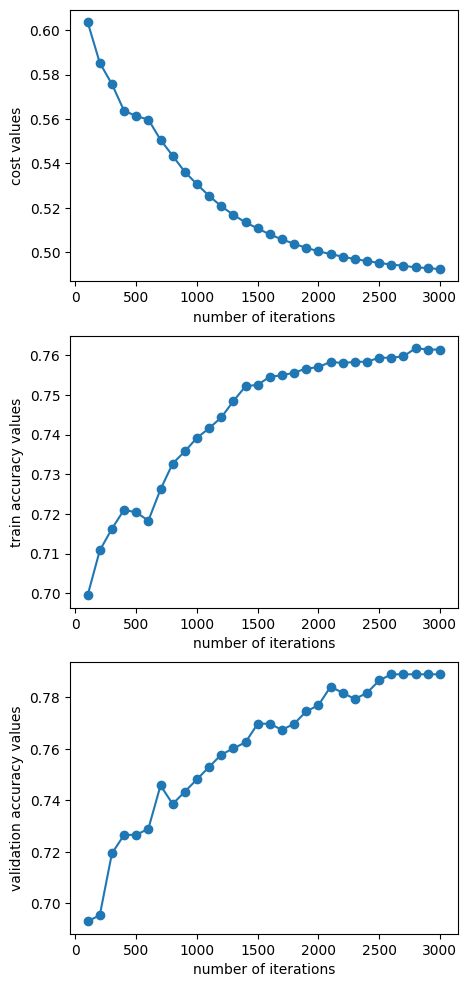

In [61]:
mlp_relu_random.plots()

In [62]:
mlp_relu_random.score(test_X, test_y)

0.7696897374701671

### Constant weights initialization

In [63]:
mlp_relu_constant = MLP(train_X, train_y, hidden_layers=[4], weights_type='Constant',\
                 activation_function='relu', lr=0.5, iterations=3000)
mlp_relu_constant.start(val_X, val_y)

iteration = 100, cost = 0.6012857250134642
iteration = 200, cost = 0.5869456302477456
iteration = 300, cost = 0.5715575283676969
iteration = 400, cost = 0.6521008786478205
iteration = 500, cost = 0.5803118777175054
iteration = 600, cost = 0.5712948127827829
iteration = 700, cost = 0.5628271389275044
iteration = 800, cost = 0.554913732870708
iteration = 900, cost = 0.5476819707685557
iteration = 1000, cost = 0.5408986827167857
iteration = 1100, cost = 0.5345586096299824
iteration = 1200, cost = 0.5294712805777667
iteration = 1300, cost = 0.524705079249272
iteration = 1400, cost = 0.5204643531454554
iteration = 1500, cost = 0.517354241123847
iteration = 1600, cost = 0.5144875015482827
iteration = 1700, cost = 0.5121982066407628
iteration = 1800, cost = 0.509542815890755
iteration = 1900, cost = 0.5080786511258825
iteration = 2000, cost = 0.5062500170452836
iteration = 2100, cost = 0.5047810533498898
iteration = 2200, cost = 0.5043630111867649
iteration = 2300, cost = 0.5029840927913386
i

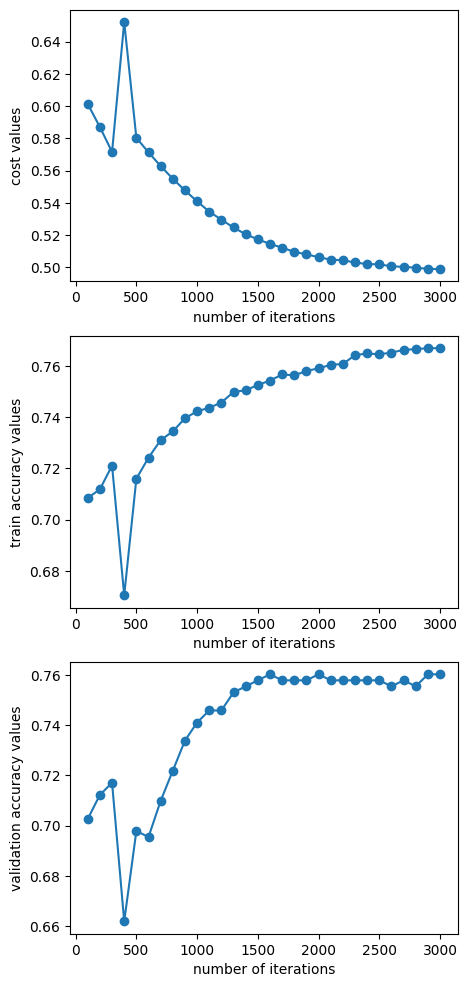

In [64]:
mlp_relu_constant.plots()

In [65]:
mlp_relu_constant.score(test_X, test_y)

0.7589498806682577

### Zero weights initialization

In [66]:
mlp_relu_zero = MLP(train_X, train_y, hidden_layers=[4], weights_type='Zero',\
                 activation_function='relu', lr=0.225, iterations=3000)
mlp_relu_zero.start(val_X, val_y)

iteration = 100, cost = 0.663393936879932
iteration = 200, cost = 0.596628032127407
iteration = 300, cost = 0.5807100671689768
iteration = 400, cost = 0.5713570794081192
iteration = 500, cost = 0.5619330774084226
iteration = 600, cost = 0.5511423539722993
iteration = 700, cost = 0.538940668546931
iteration = 800, cost = 0.5265953917445476
iteration = 900, cost = 0.5160717299738302
iteration = 1000, cost = 0.5086557708649679
iteration = 1100, cost = 0.5186452292494946
iteration = 1200, cost = 0.5185068143430775
iteration = 1300, cost = 0.5131118777984445
iteration = 1400, cost = 0.5106984880142232
iteration = 1500, cost = 0.5089281204346471
iteration = 1600, cost = 0.5051360267577343
iteration = 1700, cost = 0.5018981932468227
iteration = 1800, cost = 0.49831493350007555
iteration = 1900, cost = 0.49569069037708374
iteration = 2000, cost = 0.49465188133521826
iteration = 2100, cost = 0.5415048454614074
iteration = 2200, cost = 0.49834044593551036
iteration = 2300, cost = 0.5026328560867

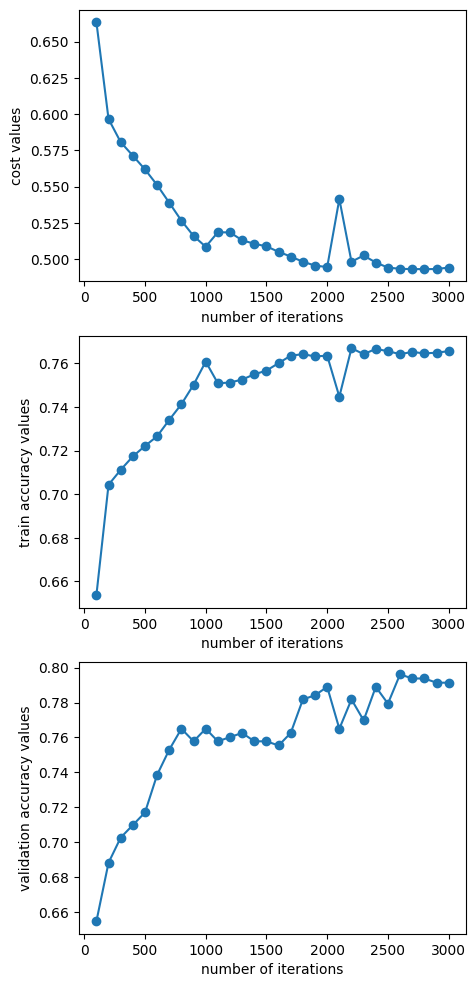

In [67]:
mlp_relu_zero.plots()

In [68]:
mlp_relu_zero.score(test_X, test_y)

0.7756563245823389

---
## tanH activation function
---

### Random weights initialialization

In [69]:
mlp_tanh_random = MLP(train_X, train_y, hidden_layers=[4], weights_type='Random',\
                 activation_function='tanh', lr=0.35, iterations=3000)
mlp_tanh_random.start(val_X, val_y)

iteration = 100, cost = 0.6686501791553204
iteration = 200, cost = 0.6607874752025994
iteration = 300, cost = 0.6504360300847133
iteration = 400, cost = 0.6427797400346515
iteration = 500, cost = 0.63652325148919
iteration = 600, cost = 0.6334128099240538
iteration = 700, cost = 0.6267473023767482
iteration = 800, cost = 0.6027645921699532
iteration = 900, cost = 0.5981073994752222
iteration = 1000, cost = 0.6000731541220184
iteration = 1100, cost = 0.6029338106226628
iteration = 1200, cost = 0.6056921610313409
iteration = 1300, cost = 0.6081527184421152
iteration = 1400, cost = 0.6103161585091795
iteration = 1500, cost = 0.6122266323943496
iteration = 1600, cost = 0.6139309768035217
iteration = 1700, cost = 0.6154690049701824
iteration = 1800, cost = 0.6168724829685401
iteration = 1900, cost = 0.6181662892822399
iteration = 2000, cost = 0.6193698739422275
iteration = 2100, cost = 0.6204985226690055
iteration = 2200, cost = 0.621564345904594
iteration = 2300, cost = 0.6225770254012527


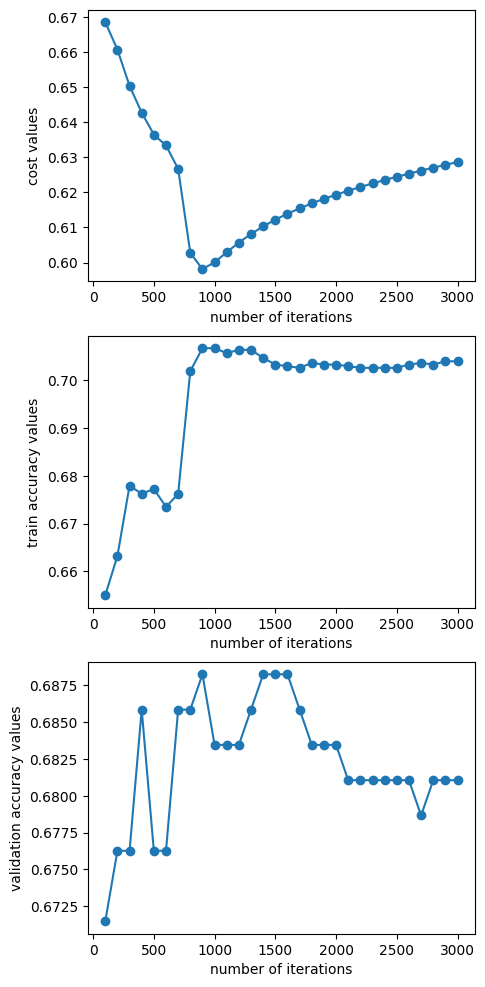

In [70]:
mlp_tanh_random.plots()

In [71]:
mlp_tanh_random.score(test_X, test_y)

0.7076372315035799

### Constant weights initialization

In [72]:
mlp_tanh_constant = MLP(train_X, train_y, hidden_layers=[4], weights_type='Constant',\
                 activation_function='tanh', lr=0.2, iterations=3000)
mlp_tanh_constant.start(val_X, val_y)

iteration = 100, cost = 0.7294515135367358
iteration = 200, cost = 0.7283862827486918
iteration = 300, cost = 0.7272660711956874
iteration = 400, cost = 0.7261620860381897
iteration = 500, cost = 0.7250755207455551
iteration = 600, cost = 0.7240059858997767
iteration = 700, cost = 0.7229530712162908
iteration = 800, cost = 0.7219163799225485
iteration = 900, cost = 0.7208955288832497
iteration = 1000, cost = 0.7198901479958738
iteration = 1100, cost = 0.7188998796042039
iteration = 1200, cost = 0.7179243779442597
iteration = 1300, cost = 0.7169633086208097
iteration = 1400, cost = 0.7160163481124823
iteration = 1500, cost = 0.7150831833035972
iteration = 1600, cost = 0.7141635110410242
iteration = 1700, cost = 0.7132570377144503
iteration = 1800, cost = 0.7123634788586068
iteration = 1900, cost = 0.7114825587760777
iteration = 2000, cost = 0.7106140101794192
iteration = 2100, cost = 0.7097575738514227
iteration = 2200, cost = 0.7089129983224176
iteration = 2300, cost = 0.70808003956360

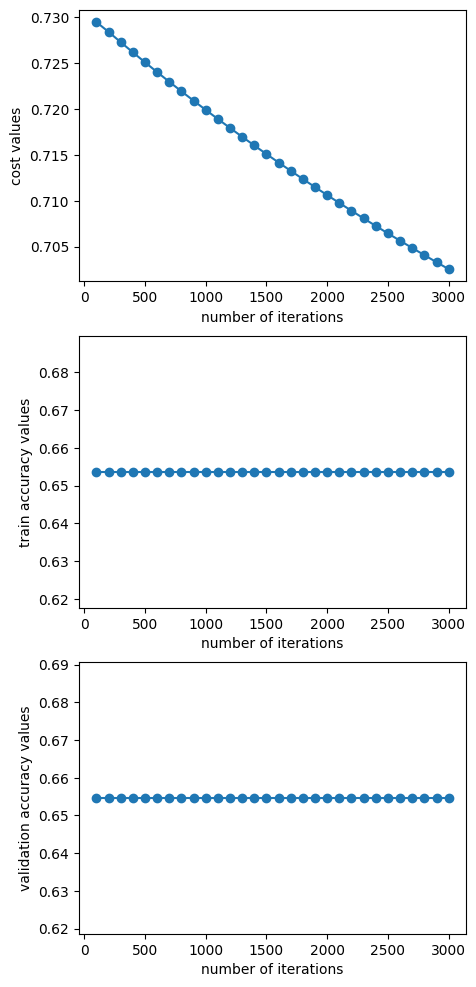

In [73]:
mlp_tanh_constant.plots()

In [74]:
mlp_tanh_constant.score(test_X, test_y)

0.652744630071599

### Zero weights initialization

In [75]:
mlp_tanh_zero = MLP(train_X, train_y, hidden_layers=[4], weights_type='Zero',\
                 activation_function='tanh', lr=0.7, iterations=3000)
mlp_tanh_zero.start(val_X, val_y)

iteration = 100, cost = 0.5887288300058805
iteration = 200, cost = 0.5518790411452423
iteration = 300, cost = 0.5719035819965992
iteration = 400, cost = 0.5619199702561061
iteration = 500, cost = 0.5530891382906287
iteration = 600, cost = 0.5451506317596556
iteration = 700, cost = 0.5380558576205311
iteration = 800, cost = 0.5317546700160252
iteration = 900, cost = 0.5261829846932058
iteration = 1000, cost = 0.5212653656323011
iteration = 1100, cost = 0.5169232201914722
iteration = 1200, cost = 0.5130813956540514
iteration = 1300, cost = 0.5096717383416037
iteration = 1400, cost = 0.506634516075238
iteration = 1500, cost = 0.5039187679412427
iteration = 1600, cost = 0.5014823214159236
iteration = 1700, cost = 0.49929213824439483
iteration = 1800, cost = 0.49732640802569883
iteration = 1900, cost = 0.49558438650514064
iteration = 2000, cost = 0.49414079665154115
iteration = 2100, cost = 0.49338887667146963
iteration = 2200, cost = 0.49335222183380917
iteration = 2300, cost = 0.493325223

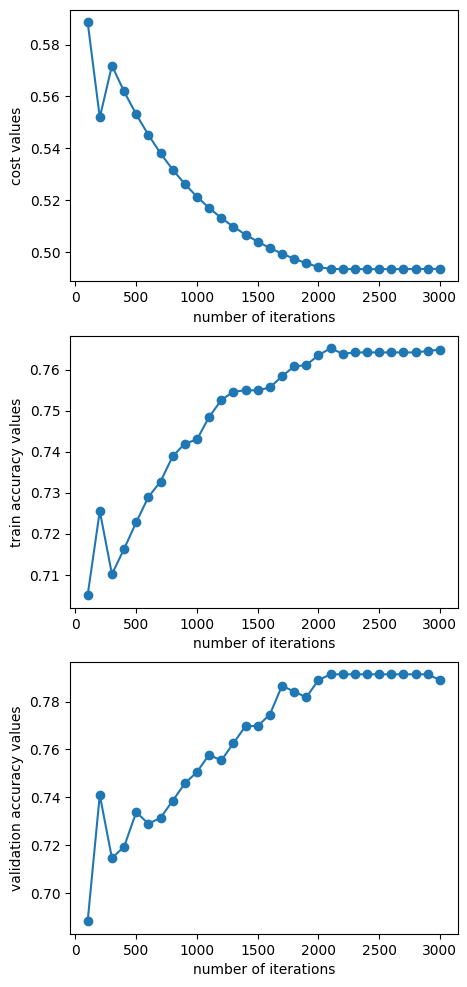

In [76]:
mlp_tanh_zero.plots()

In [77]:
mlp_tanh_zero.score(test_X, test_y)

0.7768496420047732

In [78]:
def plot_comparision(plot_dict, xlab, ylab, Title):
    names = list(plot_dict.keys())
    values = list(plot_dict.values())
    
    plt.bar(range(len(plot_dict)), values, tick_label=names)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(Title)
    plt.show()

## Comparision among different activation functions based on accuracy scores

In [79]:
random_accuracies = [mlp_sigmoid_random.score(test_X, test_y),
                     mlp_relu_random.score(test_X, test_y),
                     mlp_tanh_random.score(test_X, test_y)]

In [80]:
constant_accuracies = [mlp_sigmoid_constant.score(test_X, test_y),
                       mlp_relu_constant.score(test_X, test_y),
                       mlp_tanh_constant.score(test_X, test_y)]

In [81]:
zero_accuracies = [mlp_sigmoid_zero.score(test_X, test_y),
                   mlp_relu_zero.score(test_X, test_y),
                   mlp_tanh_zero.score(test_X, test_y)]

In [82]:
act_funcs = ['Sigmoid', 'ReLU', 'tanH']
act_range = [1, 2, 3]

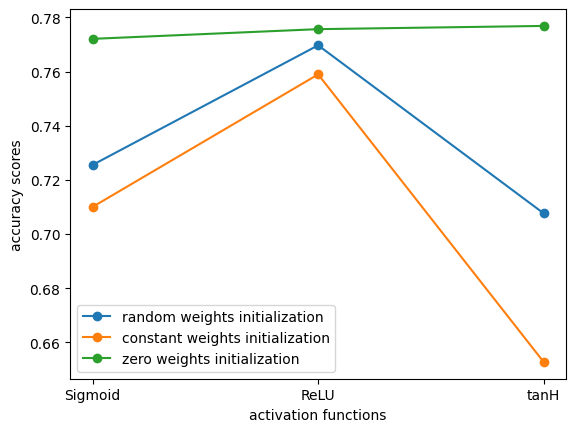

In [83]:
plt.plot(act_range, random_accuracies, 'o-', label='random weights initialization')
plt.plot(act_range, constant_accuracies, 'o-', label='constant weights initialization')
plt.plot(act_range, zero_accuracies, 'o-', label='zero weights initialization')
plt.xlabel('activation functions')
plt.ylabel('accuracy scores')
plt.xticks(act_range, act_funcs)
plt.legend()
plt.show()

## Comparision among different weight initializations

In [84]:
sigmoid_accuracies = {'random': mlp_sigmoid_random.score(test_X, test_y),
                      'constant': mlp_sigmoid_constant.score(test_X, test_y),
                      'zero': mlp_sigmoid_zero.score(test_X, test_y)}

In [85]:
relu_accuracies = {'random': mlp_relu_random.score(test_X, test_y),
                   'constant': mlp_relu_constant.score(test_X, test_y),
                   'zero': mlp_relu_zero.score(test_X, test_y)}

In [86]:
tanh_accuracies = {'random': mlp_tanh_random.score(test_X, test_y),
                   'constant': mlp_tanh_constant.score(test_X, test_y),
                   'zero': mlp_tanh_zero.score(test_X, test_y)}

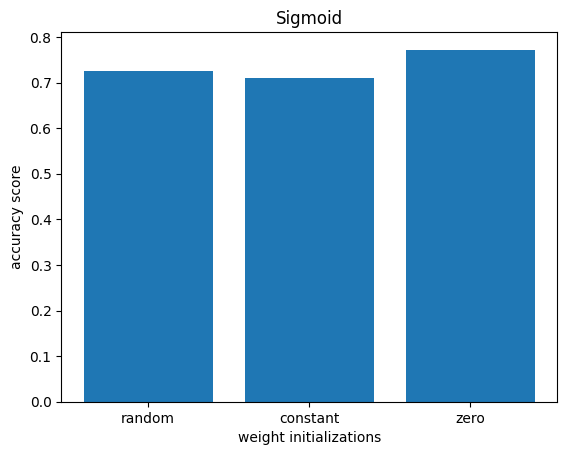

In [87]:
plot_comparision(sigmoid_accuracies, 'weight initializations', 'accuracy score', 'Sigmoid')

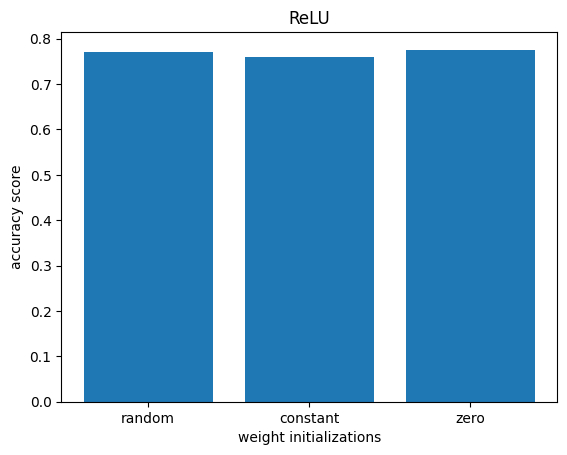

In [88]:
plot_comparision(relu_accuracies, 'weight initializations', 'accuracy score', 'ReLU')

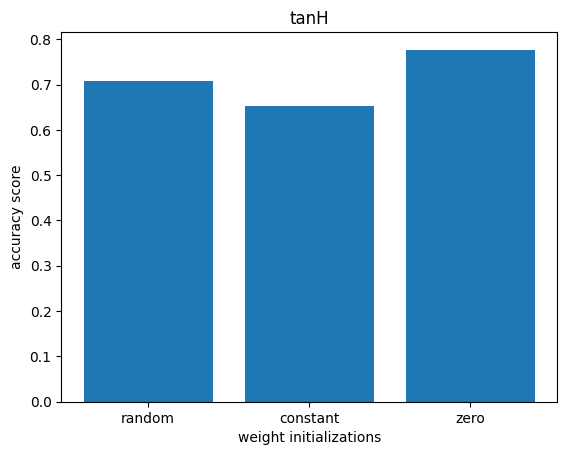

In [89]:
plot_comparision(tanh_accuracies, 'weight initializations', 'accuracy score', 'tanH')

## Changing number of hidden nodes

In [90]:
def change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function,\
                        start=2, stop=20, step=1, weights_type='Random', lr=0.2, iterations=3000):

    accuracy_scores_arr = []
    hidden_nodes_arr = []
    costs_arr_arr = []
    iterations_arr_arr = []
    val_acc_arr_arr = []
    
    for each in range(start, stop+1, step):
        mlp = MLP(train_X, train_y, hidden_layers=[each],\
              activation_function=activation_function, weights_type=weights_type, lr=lr, iterations=iterations)
        mlp.start(val_X, val_y, print_cost=False)
        
        accuracy_scores_arr.append(mlp.score(test_X, test_y))
        hidden_nodes_arr.append(each)
        costs_arr_arr.append(mlp.costs_array)
        iterations_arr_arr.append(mlp.iterations_array)
        val_acc_arr_arr.append(mlp.val_acc_array)
    
    print(f'number of hidden nodes: {hidden_nodes_arr}')
    print(f'corresponding accuracy: {accuracy_scores_arr}')
    
    nums = len(hidden_nodes_arr)
    
    
    '''plotting'''
    fig = plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    for each in range(nums):
        plt.plot(iterations_arr_arr[each], costs_arr_arr[each], 'o-', label=hidden_nodes_arr[each])
    plt.xlabel('number of iterations')
    plt.ylabel('cost values')
    # plt.title('cost values vs number of iterations')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for each in range(nums):
        plt.plot(iterations_arr_arr[each], val_acc_arr_arr[each], 'o-', label=hidden_nodes_arr[each])
    plt.xlabel('number of iterations')
    plt.ylabel('validation accuracy scores')
    # plt.title('validation accuracy scores vs number of iterations')
    plt.legend()
    
    plt.show()
    
    plt.plot(hidden_nodes_arr, accuracy_scores_arr, 'o-')
    plt.xlabel('number of hidden nodes')
    plt.ylabel('test accuracy scores')
    # plt.title('accuracy scores vs number of hidden nodes')
    plt.show()
    

---
### for sigmoid activation function
---

#### random weights initialization 

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.6670644391408115, 0.7505966587112172, 0.7255369928400954, 0.7004773269689738, 0.7159904534606205, 0.7016706443914081]


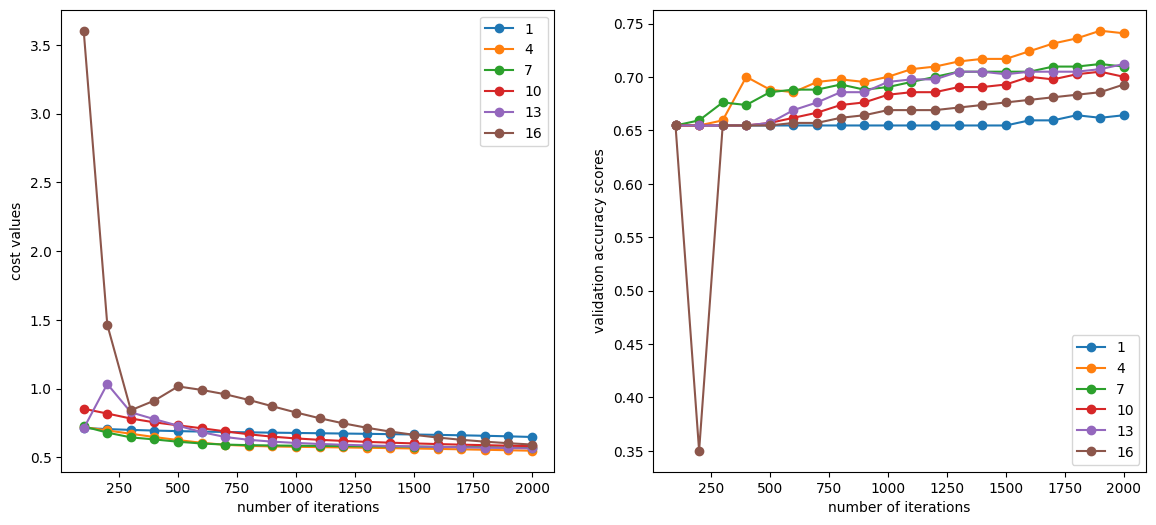

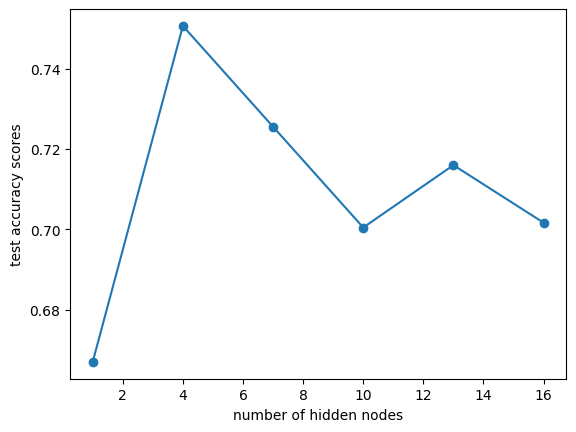

In [91]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='sigmoid',\
                        start=1, stop=16, step=3, weights_type='Random', lr=0.25, iterations=2000)

#### constant weights initialization

number of hidden nodes: [1, 5, 9, 13, 17, 21]
corresponding accuracy: [0.652744630071599, 0.652744630071599, 0.652744630071599, 0.652744630071599, 0.652744630071599, 0.5668257756563246]


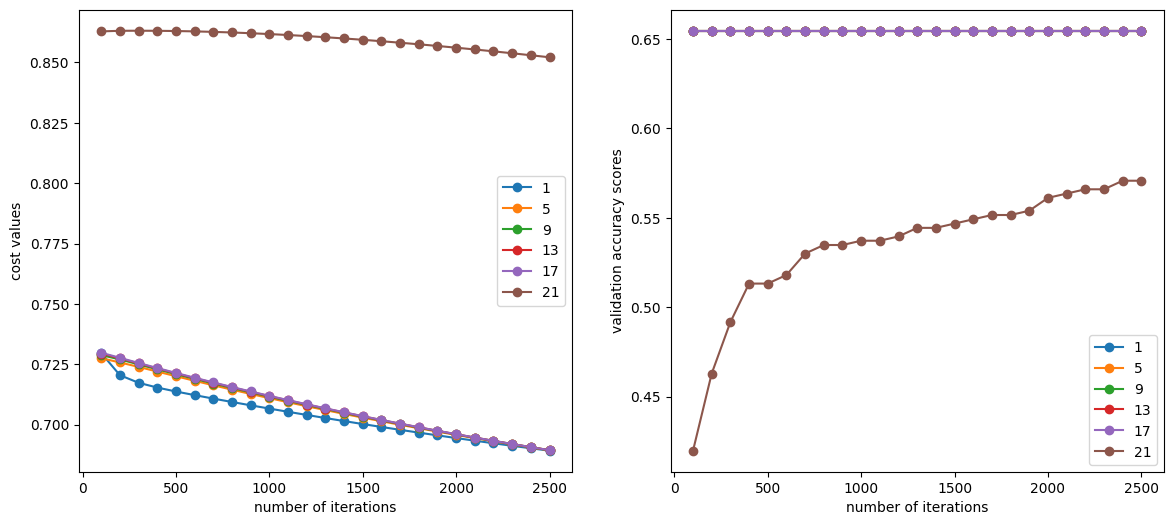

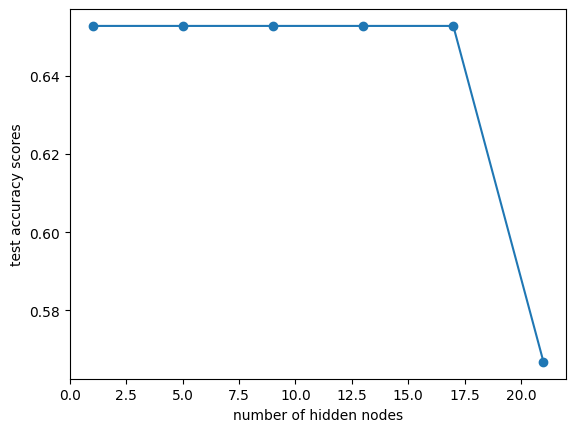

In [92]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='sigmoid',\
                        start=1, stop=21, step=4, weights_type='Constant', lr=0.05, iterations=2500)

#### zero weights initialization

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.766109785202864, 0.7613365155131265, 0.7482100238663485, 0.7362768496420048, 0.7303102625298329, 0.7267303102625299]


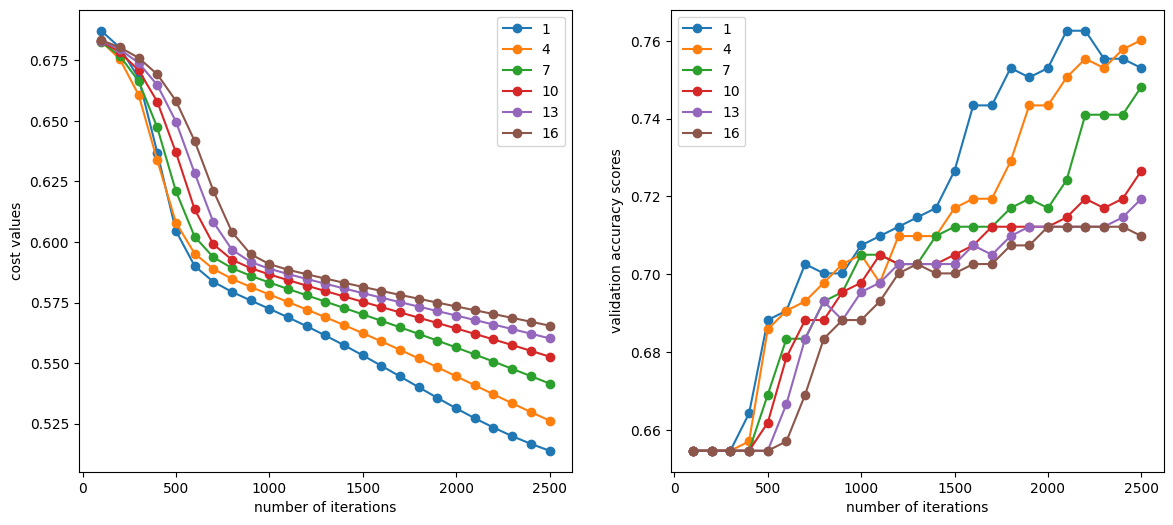

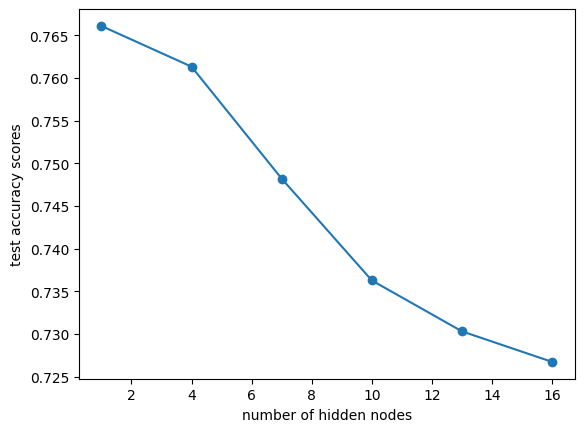

In [93]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='sigmoid',\
                        start=1, stop=16, step=3, weights_type='Zero', lr=0.25, iterations=2500)

---
### for relu activation function
---

#### random weights initialization

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.7601431980906921, 0.7780429594272077, 0.7744630071599046, 0.7553699284009546, 0.7720763723150358, 0.766109785202864]


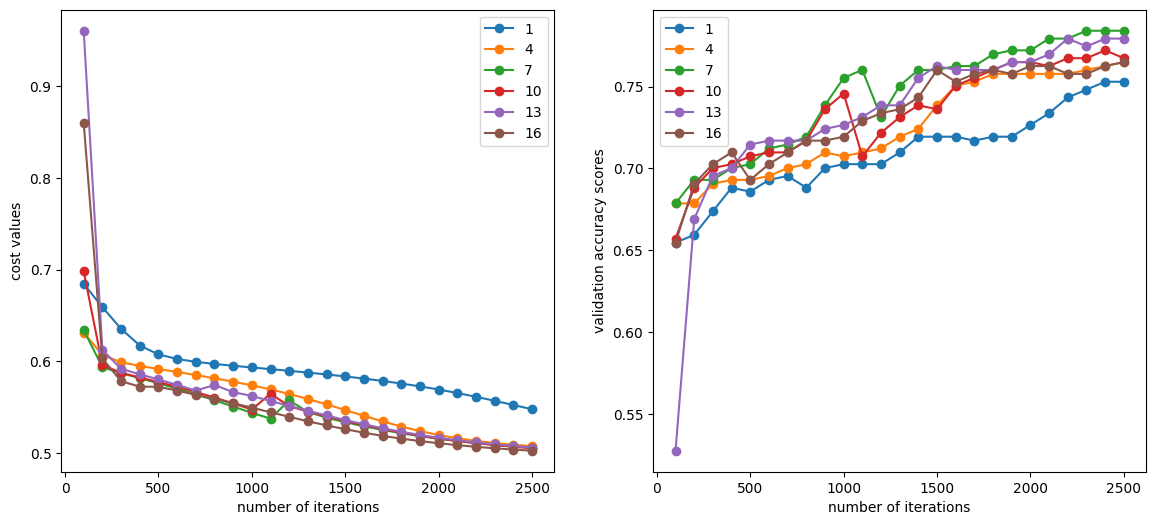

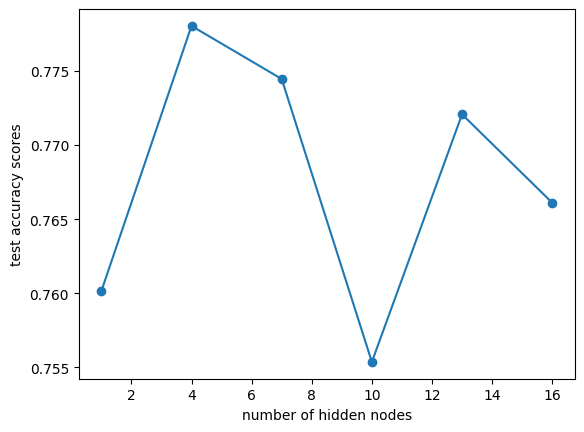

In [94]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='relu',\
                        start=1, stop=16, step=3, weights_type='Random', lr=0.1, iterations=2500)

#### constant weights initialization

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.7458233890214797, 0.766109785202864, 0.7541766109785203, 0.7673031026252983, 0.766109785202864, 0.766109785202864]


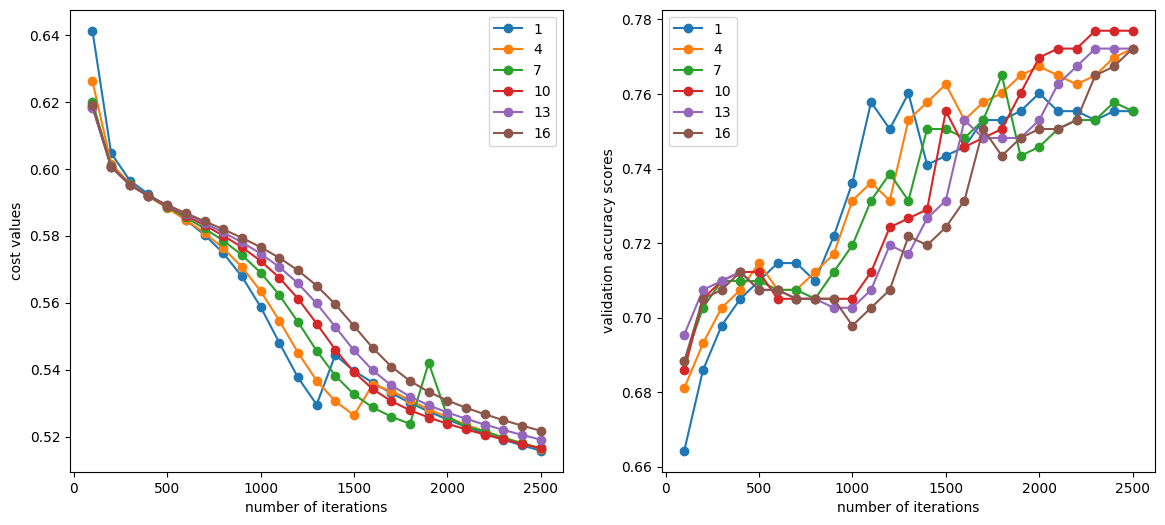

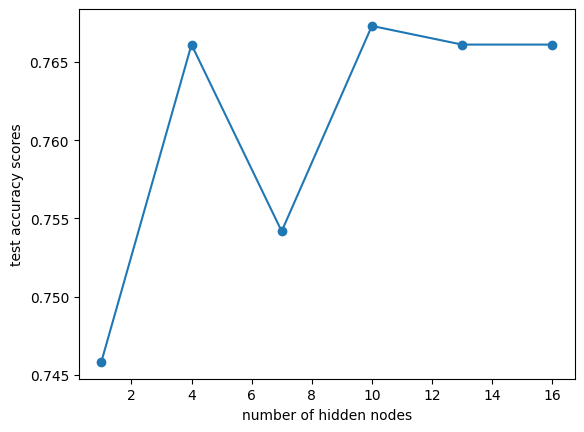

In [95]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='relu',\
                        start=1, stop=16, step=3, weights_type='Constant', lr=0.25, iterations=2500)

#### zero weights initialization

number of hidden nodes: [1, 6, 11, 16, 21]
corresponding accuracy: [0.7720763723150358, 0.7720763723150358, 0.7720763723150358, 0.7744630071599046, 0.7720763723150358]


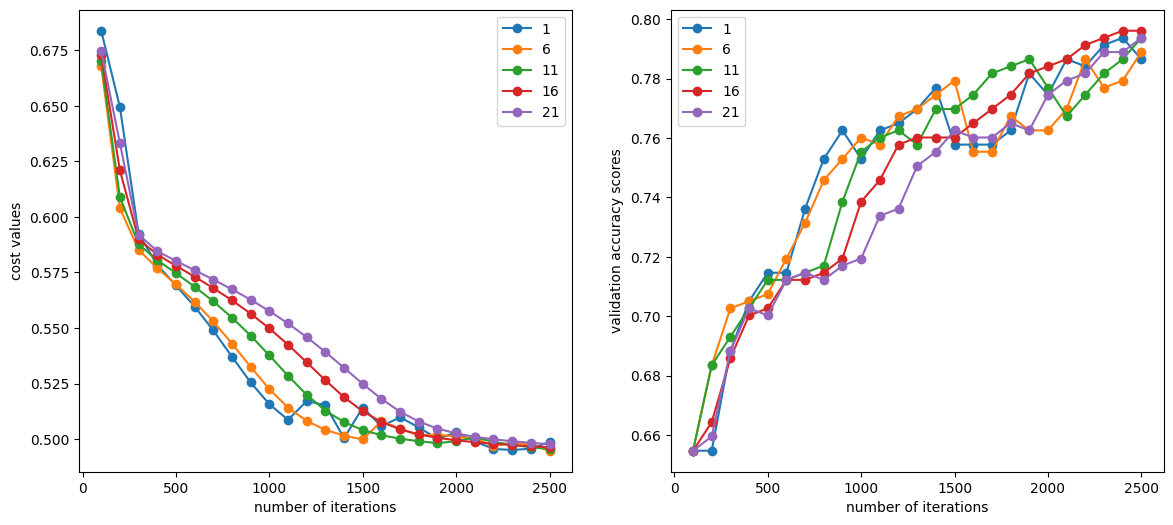

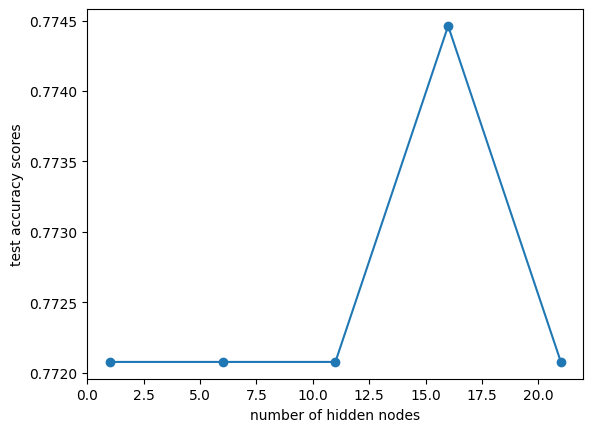

In [96]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='relu',\
                        start=1, stop=21, step=5, weights_type='Zero', lr=0.2, iterations=2500)

---
### for tanh activation function
---

#### random weights initialization

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.7255369928400954, 0.7088305489260143, 0.7183770883054893, 0.6801909307875895, 0.7064439140811456, 0.6563245823389021]


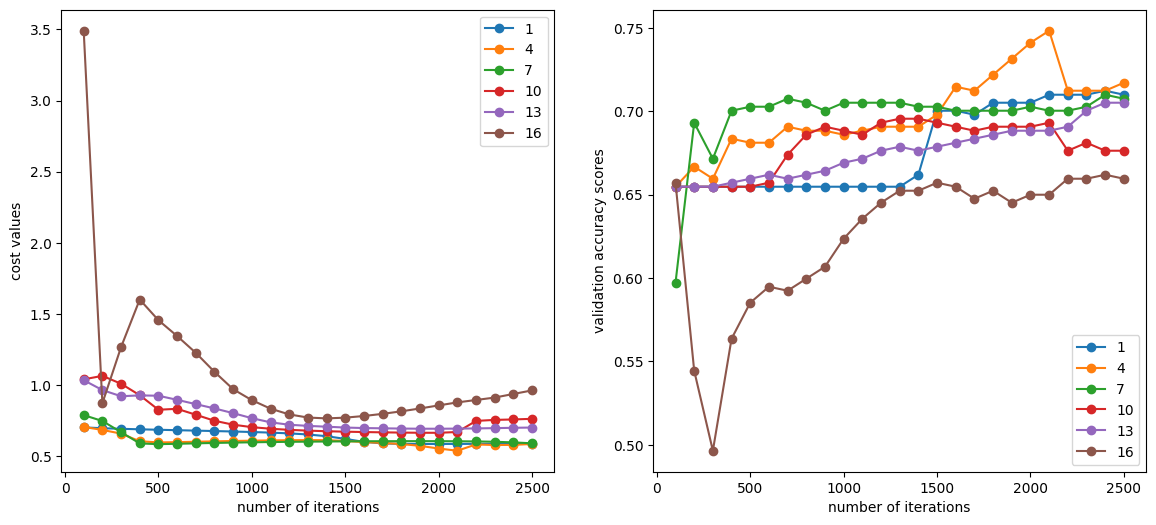

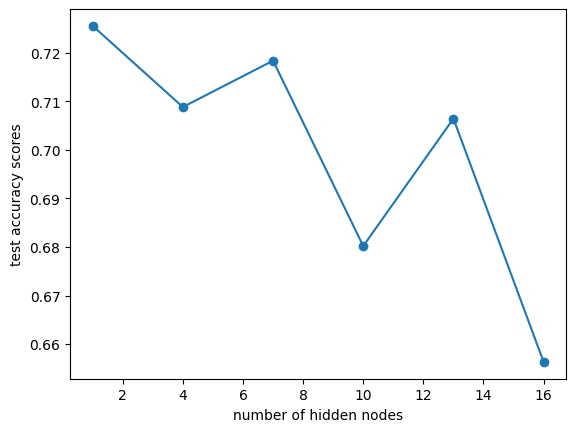

In [97]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='tanh',\
                        start=1, stop=16, step=3, weights_type='Random', lr=0.25, iterations=2500)

#### constant weights initialization

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.652744630071599, 0.652744630071599, 0.652744630071599, 0.652744630071599, 0.652744630071599, 0.652744630071599]


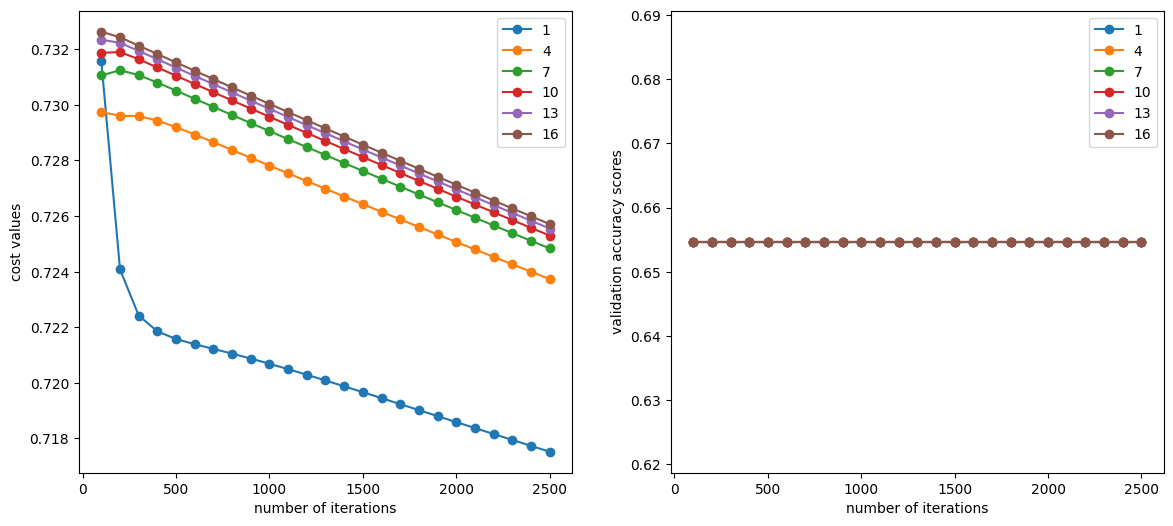

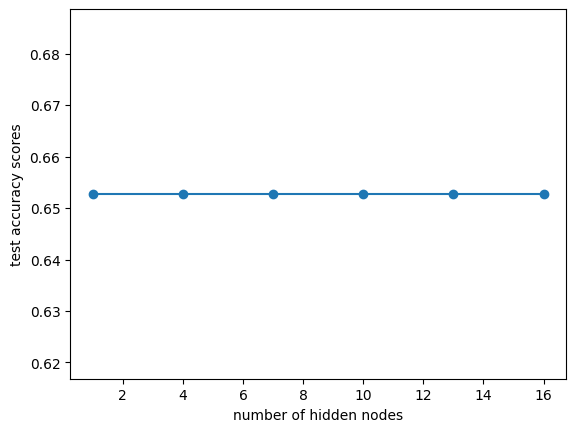

In [98]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='tanh',\
                        start=1, stop=16, step=3, weights_type='Constant', lr=0.05, iterations=2500)

#### zero weights initialization

number of hidden nodes: [1, 4, 7, 10, 13, 16]
corresponding accuracy: [0.779236276849642, 0.7565632458233891, 0.7673031026252983, 0.7565632458233891, 0.7577565632458234, 0.7637231503579952]


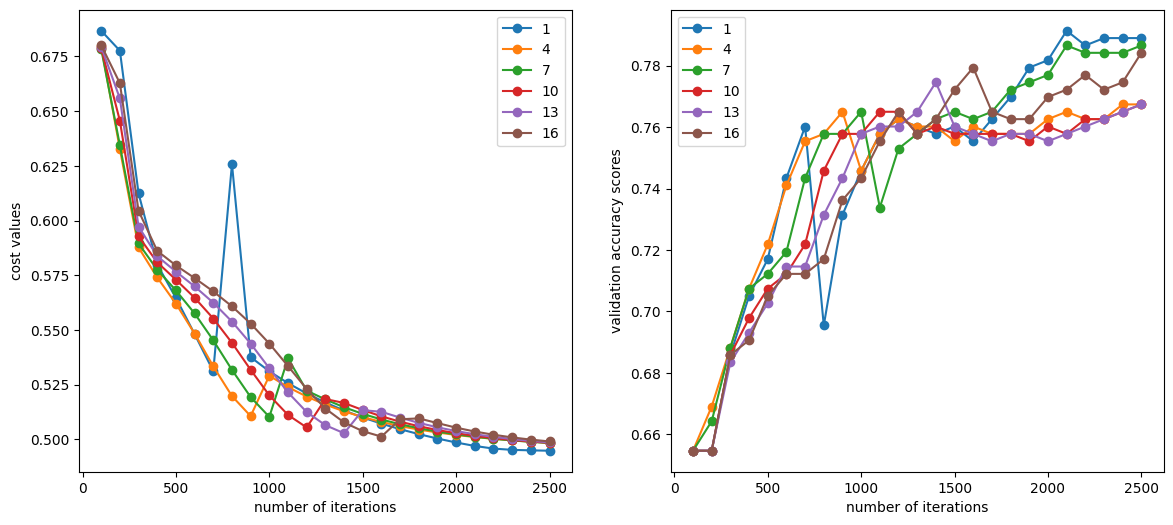

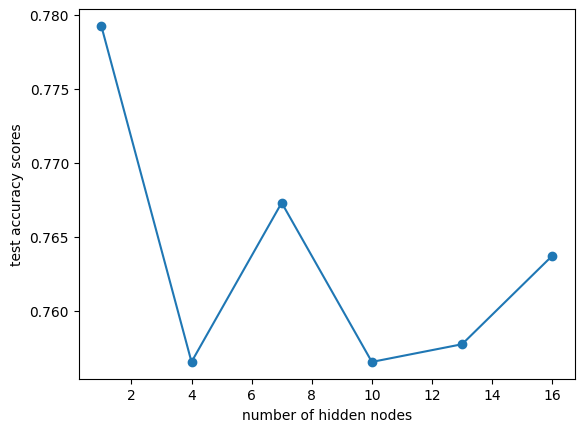

In [99]:
change_hidden_nodes(train_X, train_y, val_X, val_y, test_X, test_y, activation_function='tanh',\
                        start=1, stop=16, step=3, weights_type='Zero', lr=0.25, iterations=2500)

## Saving and loading MLP weights (using Pickle)

### Saving the weights

In [100]:
save_name = 'model_weights.pkl'
with open(save_name, 'wb') as file:  
    pickle.dump(mlp_sigmoid_random.weights, file)

### Loading the weights

In [101]:
with open(save_name, 'rb') as file:  
    pickled_weights = pickle.load(file)

pickled_weights

[array([[0.6653447482229055, 0.6301511293695229, 1.0396235691976377,
         0.3538781584376763, 0.5035681538066819, 0.5109019033780688,
         0.44200001236525416, 0.030721649658227355],
        [0.2474806479838925, 0.489488157743387, 0.2575069908362247,
         0.8069430595301148, 0.9913474563089504, -0.3241267397700564,
         0.13822237850548133, 1.0581444414010837],
        [0.24118483562167797, 0.9935841099252846, 0.9161484695051303,
         0.32293716254663457, 0.9985914696920786, 0.39349676631060604,
         0.39535877053344787, 0.7736319974253744],
        [0.10663018307229079, 0.0870822122783988, 0.18800308630069512,
         0.4472542053905035, -0.2514708558083048, 0.5992928341227215,
         0.7207298757514962, 0.5936592209788302]], dtype=object),
 array([[ 1.1183309 , -0.53283945,  0.11516306,  1.10773921],
        [ 0.21138236,  0.87542436,  1.14238485,  0.38988974],
        [-0.18622078,  1.18694167,  0.08541588,  0.63290946]])]